# Agent-Specific Evaluation Notebook of the Collaborative Reasoning Agent

In [20]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
from matplotlib.patches import Patch
import matplotlib.lines as mlines
from sklearn.metrics import roc_auc_score, auc, precision_recall_curve

project_root = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
sys.path.append(project_root)

## Setup and Configuration

In [6]:
# Set paths to pre-processed CSVs
metadata_path = os.path.join("./notebook_output/postprocessed_data", "pulse_metadata.csv")
metrics_path = os.path.join("./notebook_output/postprocessed_data", "pulse_metrics.csv")
metrics_op_path = os.path.join("./notebook_output/postprocessed_data", "pulse_metrics_operational.csv")

# Load metadata and metrics
df_metadata = pd.read_csv(metadata_path)
print(f"Loaded metadata: {df_metadata.shape}")

# Load performance metrics with and without subgroups
df_metrics_subgroup = pd.read_csv(metrics_path)
print(f"Loaded metrics with subgroups: {df_metrics_subgroup.shape}")

df_metrics = df_metrics_subgroup[
    df_metrics_subgroup["subgroup_type"] == "Overall"
].copy()
df_metrics = df_metrics.drop(columns=["subgroup_type", "subgroup_value"])
print(f"Loaded metrics without subgroups: {df_metrics.shape}")

# Load operational metrics
df_metrics_op = pd.read_csv(metrics_op_path)
print(f"Loaded operational metrics: {df_metrics_op.shape}")


# Split all loaded dataframes into _agents and _benchmark
def split_agents_benchmark(df):
    # Always include convML and convDL
    base = df[(df["model_type"] == "convML") | (df["model_type"] == "convDL")]
    # _agents: add is_agent == True
    agents = pd.concat(
        [base, df[df["is_agent"] == True]], ignore_index=True
    ).drop_duplicates()
    # _benchmark: add is_agent == False
    benchmark = pd.concat(
        [base, df[df["is_agent"] == False]], ignore_index=True
    ).drop_duplicates()
    return agents, benchmark


# Split all loaded dataframes into _agents and _benchmark
def split_agents_benchmark_op(df):
    # Always include convML and convDL
    base = df[(df["model_type"] == "convML") | (df["model_type"] == "convDL")]
    # _agents: include convML/convDL plus all rows where is_agent is True or 'all' (as string)
    agents = pd.concat(
        [base, df[df["is_agent"].isin(["True", "all"])]], ignore_index=True
    ).drop_duplicates()
    # _benchmark: include convML/convDL plus all rows where is_agent is False or 'all' (as string)
    benchmark = pd.concat(
        [base, df[df["is_agent"].isin(["False", "all"])]], ignore_index=True
    ).drop_duplicates()
    return agents, benchmark


df_metadata_agents, df_metadata_benchmark = split_agents_benchmark(df_metadata)
df_metrics_subgroup_agents, df_metrics_subgroup_benchmark = split_agents_benchmark(
    df_metrics_subgroup
)
df_metrics_agents, df_metrics_benchmark = split_agents_benchmark(df_metrics)
df_metrics_op_agents, df_metrics_op_benchmark = split_agents_benchmark_op(df_metrics_op)
# Drop specified columns from df_metrics_op_benchmark
df_metrics_op_benchmark = df_metrics_op_benchmark.drop(
    columns=[
        "avg_step_tokenization_time",
        "avg_step_inference_time",
        "avg_step_input_tokens",
        "avg_step_output_tokens",
    ],
    errors="ignore",
)

print(
    f"df_metadata_agents: {df_metadata_agents.shape}, df_metadata_benchmark: {df_metadata_benchmark.shape}"
)
print(
    f"df_metrics_subgroup_agents: {df_metrics_subgroup_agents.shape}, df_metrics_subgroup_benchmark: {df_metrics_subgroup_benchmark.shape}"
)
print(
    f"df_metrics_agents: {df_metrics_agents.shape}, df_metrics_benchmark: {df_metrics_benchmark.shape}"
)
print(
    f"df_metrics_op_agents: {df_metrics_op_agents.shape}, df_metrics_op_benchmark: {df_metrics_op_benchmark.shape}"
)

/var/folders/r1/8n2p36gx2ydfw7wf826zxyh00000gn/T/ipykernel_47515/595344355.py:7: DtypeWarning: Columns (3,16,20,27,28,29,30,31,33,34,35,36,43,44,47,48,49,50,51,52,53,54,55,56,61,67,70,76,77,78,80,81,83,84,91,92,93) have mixed types. Specify dtype option on import or set low_memory=False.
  df_metadata = pd.read_csv(metadata_path)


Loaded metadata: (1062044, 96)
Loaded metrics with subgroups: (5704, 25)
Loaded metrics without subgroups: (612, 23)
Loaded operational metrics: (837, 22)
df_metadata_agents: (851698, 96), df_metadata_benchmark: (247480, 96)
df_metrics_subgroup_agents: (2856, 25), df_metrics_subgroup_benchmark: (3352, 25)
df_metrics_agents: (306, 23), df_metrics_benchmark: (360, 23)
df_metrics_op_agents: (385, 22), df_metrics_op_benchmark: (463, 18)


In [7]:
# Global output directory for all visualizations
OUTPUT_BASE_DIR = os.path.join(".", "notebook_output", "pulse_agents_colagent")

TASK_MAPPING = {
    "mortality": ("Mortality", {"case": "#D14E70", "control": "#F0B0C0"}),  # Raspberry
    "aki": ("AKI", {"case": "#3A78B5", "control": "#A0D0F0"}),  # Blue
    "sepsis": ("Sepsis", {"case": "#F9C27B", "control": "#FFE6A7"}),  # Amber/Gold
}

DATASET_MAPPING = {
    "hirid": ("HiRID", "#793FBB"),  # Purple
    "miiv": ("MIMIC-IV", "#17AB6F"),  # Green
    "eicu": ("eICU", "#FC8D5F"),  # Orange
}
MODEL_MAPPING = {
    # convML: slightly darker, more prominent blues (light to dark)
    "RandomForest": "#c9daf6",  # light blue, slightly darker and bluer
    "XGBoost": "#4f8ad1",  # deeper blue, more saturated
    # convDL: slightly darker, more prominent greens (light to dark)
    "CNN": "#c6eedb",  # light mint green, slightly darker
    "InceptionTime": "#7fd6b1",  # medium mint green, slightly darker
    "LSTM": "#3ca97d",  # deeper green, more saturated
    "GRU": "#217a5a",  # even deeper green
    # LLMs: vivid, distinct, friendly (legend only)
    "OpenAI-o3": "#ff66c3",  # vivid magenta (first agent color in LLM_COLOR_FAMILIES)
    "Claude-Sonnet-4": "#1080e2",  # vivid blue (first agent color in LLM_COLOR_FAMILIES)
    "Grok-4": "#b44fd1",  # vivid purple (first agent color in LLM_COLOR_FAMILIES)
    "Gemini-2.5-Pro": "#8be600",  # vivid lime green (first agent color in LLM_COLOR_FAMILIES)
    "Gemini-2.5-Flash": "#ff7c1a",  # vivid gold (first agent color in LLM_COLOR_FAMILIES)
    "Llama-3.1-8B-Instruct": "#4cb0c3",  # vivid turquoise (first agent color in LLM_COLOR_FAMILIES)
    "Deepseek-R1-Distill-Llama-8B": "#ffa233",  # vivid orange (first agent color in LLM_COLOR_FAMILIES)
    "Mistral-7B-Instruct-v0.3": "#8f5ad8",  # vivid violet (first agent color in LLM_COLOR_FAMILIES)
    "Gemma-3-4B-it": "#00e699",  # vivid mint green (first agent color in LLM_COLOR_FAMILIES)
    "MedGemma-4B-it": "#c2338c",  # vivid magenta (first agent color in LLM_COLOR_FAMILIES)
}

PROMPTING_ID_MAPPING = {
    "Aggregation": "#1f77b4",  # Vivid Blue
    "Zero-Shot": "#ff7f0e",  # Vibrant Orange
    "One-Shot": "#9cf177",  # Modern Purple
    "Few-Shot (3)": "#fbe844",  # Bold Red
    "CoT": "#2ca02c",  # Fresh Green
    "SumAgent": "#ebb128",  # Playful Pink
    "ColAgent": "#b141e9",  # Lively Cyan
    "ClinFlowAgent": "#36eaab",  # Warm Brown
    "HybReAgent": "#f13636",  # Energetic Yellow-Green
}

CONVML_MODELS = ["RandomForest", "XGBoost"]
CONVDL_MODELS = ["CNN", "InceptionTime", "GRU", "LSTM"]
LLM_MODELS = [
    "OpenAI-o3",
    "Claude-Sonnet-4",
    "Grok-4",
    "Gemini-2.5-Pro",
    "Gemini-2.5-Flash",
    "Llama-3.1-8B-Instruct",
    "Deepseek-R1-Distill-Llama-8B",
    "Mistral-7B-Instruct-v0.3",
    "Gemma-3-4B-it", 
    "MedGemma-4B-it",
]

SUBGROUP_MAPPING = {
    "Sex": {"Male": "#1f4e79", "Female": "#c5282f"},  # Dark blue, Dark red
    "Age": {
        "18-65 Years": "#ddbf94",  # Light beige
        "65-75 Years": "#c19a6b",  # Medium beige
        "75-91 Years": "#8b7355",  # Dark beige
    },
    "BMI": {
        "BMI < 18.5 kg/m2": "#b8b8b8",  # Light silver
        "BMI 18.5-25 kg/m2": "#9d9d9d",  # Medium light silver
        "BMI 25-30 kg/m2": "#808080",  # Medium dark silver
        "BMI > 30 kg/m2": "#2c3539",  # Dark gunmetal
    },
}

METRICS_LIST = [
    "AUROC",
    "AUPRC",
    "Normalized AUPRC",
    "Min(+P, Se)",
    "Sensitivity (Recall)",
    "Specificity",
    "Precision",
    "F1 Score",
    "Accuracy",
    "Balanced Accuracy",
    "MCC",
    "Cohen's Kappa",
]

LLM_ALL_PROMPTING_IDS = sorted(
    x
    for x in df_metadata.loc[
        ~df_metadata["model_prompting_id"].isin(CONVML_MODELS + CONVDL_MODELS),
        "model_prompting_id",
    ].unique()
    if isinstance(x, str)
)

# Define agentic prompting methods
AGENTIC_PROMPTING_IDS = [
    "SumAgent",
    "ColAgent",
    "ClinFlowAgent",
    "HybReAgent",
]

# Define standard prompting methods
STANDARD_PROMPTING_IDS = [
    "Aggregation",
    "Zero-Shot",
    "One-Shot",
    "Few-Shot (3)",
    "CoT",
]

LLM_COLOR_FAMILIES = {
    "OpenAI-o3": {
        "standard_prompting": [
            "#fff0fa",  # 1 - very pale pink
            "#ffd6f2",  # 2 - light bubblegum
            "#ffb3e6",  # 3 - pastel bubblegum
            "#ff99db",  # 4 - soft bubblegum
            "#ff7fcf",  # 5 - bubblegum
        ],  # Pastel magenta to vivid pink
        "agents": [
            "#ff66c3",  # 6 - vivid bubblegum
            "#ff4db8",  # 7 - strong bubblegum
            "#ff33ac",  # 8 - deep bubblegum
            "#ff199f",  # 9 - deepest bubblegum
        ],  # Deeper magenta to lighter berry
    },
    "Claude-Sonnet-4": {
        "standard_prompting": [
            "#eaf6ff",
            "#b6dcff",
            "#7fc0ff",
            "#4da3ff",
            "#1987ff",
        ],  # Pastel blue to vivid azure
        "agents": [
            "#1080e2",
            "#0c6cc5",
            "#1152ad",
            "#114d83",
        ],  # Deeper blue to lighter navy
    },
    "Grok-4": {
        "standard_prompting": [
            "#fbe6ff",  # 1 - very light pink-lilac
            "#f3c2fa",  # 2 - pastel pink-lilac
            "#e6a8f7",  # 3 - soft lilac
            "#d98cf0",  # 4 - light magenta-lilac
            "#c96ae6",  # 5 - medium lilac
        ],  # Pastel lilac to vivid purple
        "agents": [
            "#b44fd1",  # 6 - vivid lilac
            "#9443c3",  # 7 - strong blue-violet
            "#7d2ca2",  # 8 - deep blue-violet
            "#61247C",  # 9 - darkest, but lighter than pure indigo
        ],  # Deeper purple to lighter violet
    },
    "Gemini-2.5-Pro": {
        "standard_prompting": [
            "#f7ffe0",  # 1 - very pale lime
            "#eaffb3",  # 2 - light lime
            "#d4ff66",  # 3 - pastel lime
            "#baff33",  # 4 - soft lime
            "#a0ff00",  # 5 - vivid lime
        ],  # Pastel green to vivid lime
        "agents": [
            "#8be600",  # 6 - lime green
            "#7acc1a",  # 7 - yellow-green
            "#6ab300",  # 8 - olive-lime
            "#5a9900",  # 9 - darkest, yellowish green
        ],  # Deeper lime/green to lighter green
    },
    "Gemini-2.5-Flash": {
        "standard_prompting": [
            "#fff4e6",  # 1 - very light orange
            "#ffd9b3",  # 2 - light peach
            "#ffc285",  # 3 - soft orange
            "#ffad5c",  # 4 - rich orange
            "#ff9800",  # 5 - vivid orange
        ],  # Pastel yellow to vivid gold
        "agents": [
            "#ff7c1a",  # 6 - deep orange
            "#ff5a36",  # 7 - orange-red
            "#e64a19",  # 8 - strong reddish orange
            "#e65c00",
        ],  # Deeper gold to lighter orange-brown
    },
    "Llama-3.1-8B-Instruct": {
        "standard_prompting": [
            "#e0ffff",  # 1 - very light aqua
            "#b3eaf2",  # 2 - lighter aqua
            "#99dbe6",  # 3 - light pastel aqua
            "#7fcddb",  # 4 - pastel aqua
            "#66becf",  # 5 - soft aqua
        ],  # Pastel aqua to vivid turquoise
        "agents": [
            "#4cb0c3",  # 6 - medium aqua
            "#3391a7",  # 7 - deeper aqua
            "#2a7c8c",  # 8 - dark teal-blue
            "#2a6a7c",  # 9 - darkest, deep blue-teal
        ],  # Deeper turquoise to lighter teal
    },
    "Deepseek-R1-Distill-Llama-8B": {
        "standard_prompting": [
            "#fff3e0",  # 1 - very light peach
            "#ffe3c2",  # 2 - light cream
            "#ffd39f",  # 3 - pale yellow-orange
            "#ffc278",  # 4 - soft yellow-orange
            "#ffb34d",  # 5 - light amber
        ],  # Pastel peach to vivid orange
        "agents": [
            "#ffa233",  # 6 - amber
            "#e88c1a",  # 7 - brownish amber
            "#c97a1a",  # 8 - brown-orange
            "#be7835",  # 9 - brown
        ],  # Deeper orange to lighter brown
    },
    "Mistral-7B-Instruct-v0.3": {
        "standard_prompting": [
            "#f6efff",  # 1 - very light lavender
            "#e3d1fa",  # 2 - pale lavender
            "#d1b3f6",  # 3 - light pastel purple
            "#be95ea",  # 4 - soft purple
            "#a97fdc",  # 5 - medium purple
        ],  # Pastel lilac to vivid violet
        "agents": [
            "#8f5ad8",  # 6 - vivid purple
            "#7a3fc7",  # 7 - strong purple
            "#6a1bb1",  # 8 - deep purple
            "#502491",  # 9 - darkest, but not black
        ],  # Deeper violet to lighter purple
    },
    "Gemma-3-4B-it": {
        "standard_prompting": [
            "#e6fff7",  # 1 - very pale blue-green
            "#b3ffe6",  # 2 - light blue-green
            "#80ffd1",  # 3 - pastel blue-green
            "#4dffbe",  # 4 - soft blue-green
            "#1affaa",  # 5 - vivid blue-green
        ],  # Pastel mint to vivid green
        "agents": [
            "#00e699",  # 6 - cool green
            "#00cc88",  # 7 - blueish green
            "#00b377",  # 8 - deep blue-green
            "#009966",  # 9 - darkest, blueish green
        ],  # Deeper mint/green to lighter green
    },
    "MedGemma-4B-it": {
        "standard_prompting": [
            "#fbe6f6",  # 1 - very pale berry
            "#f5c2e3",  # 2 - light berry
            "#ee99cc",  # 3 - pastel berry
            "#e673b8",  # 4 - soft berry
            "#d94da3",  # 5 - berry
        ],  # Pastel pink to vivid magenta
        "agents": [
            "#c2338c",  # 6 - vivid berry
            "#a61a70",  # 7 - strong berry
            "#8c005a",  # 8 - deep berry
            "#66003f",  # 9 - darkest berry
        ],  # Deeper magenta to lighter pink/purple
    },
}

# Create unified model-prompting mapping
MODEL_PROMPTING_ID_MAPPING = {}

# Add convML and convDL models (unchanged)
for model in CONVML_MODELS + CONVDL_MODELS:
    MODEL_PROMPTING_ID_MAPPING[model] = MODEL_MAPPING[model]

# Add LLM models with integrated color schemes
for model, color_family in LLM_COLOR_FAMILIES.items():
    # Assign agent colors
    for i, agent_id in enumerate(AGENTIC_PROMPTING_IDS):
        key = f"{model}, {agent_id}"
        if i < len(color_family["agents"]):
            MODEL_PROMPTING_ID_MAPPING[key] = color_family["agents"][i]
        else:
            # Fallback to cycling through available agent colors
            MODEL_PROMPTING_ID_MAPPING[key] = color_family["agents"][
                i % len(color_family["agents"])
            ]

    # Assign standard prompting colors
    for i, standard_id in enumerate(STANDARD_PROMPTING_IDS):
        key = f"{model}, {standard_id}"
        if i < len(color_family["standard_prompting"]):
            MODEL_PROMPTING_ID_MAPPING[key] = color_family["standard_prompting"][i]
        else:
            # Fallback to cycling through available standard colors
            MODEL_PROMPTING_ID_MAPPING[key] = color_family["standard_prompting"][
                i % len(color_family["standard_prompting"])
            ]

# Function to get model-specific color
def get_model_color(model):
    if model in MODEL_MAPPING:
        # Use the color defined in MODEL_MAPPING for convML/convDL models
        return MODEL_MAPPING[model]

### Agent-specific Metadata Overview

In [8]:
# Filter df_metadata_agents to only include Collaborative Reasoning Agent
df_metadata_cra = df_metadata_agents[df_metadata_agents["prompting_id"] == "ColAgent"].copy()
print(f"df_metadata_cra: {df_metadata_cra.shape}")

# Delete columns that have only missing values
columns_before = df_metadata_cra.shape[1]
df_metadata_cra = df_metadata_cra.dropna(axis=1, how='all')
columns_after = df_metadata_cra.shape[1]
print(f"Removed {columns_before - columns_after} columns with only missing values")
print(f"df_metadata_cra after cleanup: {df_metadata_cra.shape}")

# Comprehensive analysis of df_metadata_cra characteristics
print("=" * 80)
print("COMPREHENSIVE SUMMARY OF COLLABORATIVE REASONING AGENT METADATA")
print("=" * 80)

# Basic shape and structure
print(f"\n1. DATASET OVERVIEW")
print(f"   Shape: {df_metadata_cra.shape[0]} rows × {df_metadata_cra.shape[1]} columns")
print(f"   Total experiments: {len(df_metadata_cra)}")

# Column information
print(f"\n2. AVAILABLE COLUMNS")
print(f"   Columns: {list(df_metadata_cra.columns)}")

# Model distribution
print(f"\n3. MODEL DISTRIBUTION")
if 'model' in df_metadata_cra.columns:
    model_counts = df_metadata_cra['model'].value_counts()
    print(f"   Models tested: {len(model_counts)} unique models")
    for model, count in model_counts.items():
        print(f"   - {model}: {count} rows")
else:
    print("   No 'model' column found")

# Task distribution
print(f"\n4. TASK DISTRIBUTION")
if 'task' in df_metadata_cra.columns:
    task_counts = df_metadata_cra['task'].value_counts()
    print(f"   Tasks evaluated: {len(task_counts)} unique tasks")
    for task, count in task_counts.items():
        print(f"   - {task}: {count} rows")
else:
    print("   No 'task' column found")

# Dataset distribution
print(f"\n5. DATASET DISTRIBUTION")
if 'dataset' in df_metadata_cra.columns:
    dataset_counts = df_metadata_cra['dataset'].value_counts()
    print(f"   Datasets used: {len(dataset_counts)} unique datasets")
    for dataset, count in dataset_counts.items():
        print(f"   - {dataset}: {count} rows")
else:
    print("   No 'dataset' column found")

# Model type distribution
print(f"\n6. MODEL TYPE DISTRIBUTION")
if 'model_type' in df_metadata_cra.columns:
    model_type_counts = df_metadata_cra['model_type'].value_counts()
    print(f"   Model types: {len(model_type_counts)} unique types")
    for model_type, count in model_type_counts.items():
        print(f"   - {model_type}: {count} experiments")
else:
    print("   No 'model_type' column found")

# Prompting ID verification
print(f"\n7. PROMPTING METHOD VERIFICATION")
if 'prompting_id' in df_metadata_cra.columns:
    prompting_counts = df_metadata_cra['prompting_id'].value_counts()
    print(f"   Prompting methods: {len(prompting_counts)} unique methods")
    for prompting, count in prompting_counts.items():
        print(f"   - {prompting}: {count} experiments")
else:
    print("   No 'prompting_id' column found")

# Agent verification
print(f"\n8. AGENT STATUS VERIFICATION")
if 'is_agent' in df_metadata_cra.columns:
    agent_counts = df_metadata_cra['is_agent'].value_counts()
    print(f"   Agent status distribution:")
    for status, count in agent_counts.items():
        print(f"   - is_agent={status}: {count} experiments")
else:
    print("   No 'is_agent' column found")

# Cross-tabulation analysis
print(f"\n9. CROSS-TABULATION ANALYSIS")
if all(col in df_metadata_cra.columns for col in ['model', 'task', 'dataset']):
    print(f"   Model × Task × Dataset combinations:")
    cross_tab = df_metadata_cra.groupby(['model', 'task', 'dataset']).size().reset_index(name='count')
    print(f"   Total unique combinations: {len(cross_tab)}")
    
    # Show coverage matrix
    print(f"\n   Coverage by Task and Dataset:")
    coverage = df_metadata_cra.pivot_table(
        index='task', 
        columns='dataset', 
        values='model', 
        aggfunc='count', 
        fill_value=0
    )
    print(coverage)
    
    print(f"\n   Coverage by Model and Task:")
    model_task_coverage = df_metadata_cra.pivot_table(
        index='model', 
        columns='task', 
        values='dataset', 
        aggfunc='count', 
        fill_value=0
    )
    print(model_task_coverage)

# Model-prompting ID combinations
print(f"\n10. MODEL-PROMPTING COMBINATIONS")
if 'model_prompting_id' in df_metadata_cra.columns:
    model_prompting_counts = df_metadata_cra['model_prompting_id'].value_counts()
    print(f"    Unique model-prompting combinations: {len(model_prompting_counts)}")
    for combo, count in model_prompting_counts.items():
        print(f"    - {combo}: {count} experiments")

# Temporal information (if available)
print(f"\n11. TEMPORAL INFORMATION")
time_columns = [col for col in df_metadata_cra.columns if any(keyword in col.lower() for keyword in ['time', 'date', 'duration', 'created'])]
if time_columns:
    print(f"    Time-related columns found: {time_columns}")
    for col in time_columns:
        if df_metadata_cra[col].dtype in ['datetime64[ns]', 'object']:
            try:
                # Try to convert to datetime if not already
                temp_series = pd.to_datetime(df_metadata_cra[col], errors='coerce')
                if not temp_series.isna().all():
                    print(f"    - {col}: {temp_series.min()} to {temp_series.max()}")
            except:
                print(f"    - {col}: Unable to parse as datetime")
        else:
            print(f"    - {col}: {df_metadata_cra[col].describe()}")
else:
    print("    No time-related columns found")

# Configuration and parameter information
print(f"\n12. CONFIGURATION PARAMETERS")
config_columns = [col for col in df_metadata_cra.columns if any(keyword in col.lower() for keyword in ['config', 'param', 'setting', 'seed', 'temperature', 'max_tokens'])]
if config_columns:
    print(f"    Configuration columns found: {config_columns}")
    for col in config_columns:
        unique_vals = df_metadata_cra[col].nunique()
        if unique_vals <= 10:  # Show all values if few unique
            print(f"    - {col}: {sorted(df_metadata_cra[col].unique())}")
        else:
            print(f"    - {col}: {unique_vals} unique values, range: {df_metadata_cra[col].min()} to {df_metadata_cra[col].max()}")
else:
    print("    No configuration-related columns found")

# File and path information
print(f"\n13. FILE AND PATH INFORMATION")
path_columns = [col for col in df_metadata_cra.columns if any(keyword in col.lower() for keyword in ['path', 'file', 'dir', 'output'])]
if path_columns:
    print(f"    Path-related columns found: {path_columns}")
    for col in path_columns:
        unique_count = df_metadata_cra[col].nunique()
        print(f"    - {col}: {unique_count} unique paths")
        if unique_count <= 5:  # Show examples for few paths
            print(f"      Examples: {list(df_metadata_cra[col].unique()[:3])}")
else:
    print("    No path-related columns found")

# Missing data analysis
print(f"\n14. DATA COMPLETENESS ANALYSIS")
missing_data = df_metadata_cra.isnull().sum()
missing_percentage = (missing_data / len(df_metadata_cra)) * 100
print(f"    Columns with missing data:")
for col, missing_count in missing_data[missing_data > 0].items():
    print(f"    - {col}: {missing_count} missing ({missing_percentage[col]:.1f}%)")
if missing_data.sum() == 0:
    print("    No missing data found - dataset is complete!")

# Sample data preview
print(f"\n15. SAMPLE DATA PREVIEW")
print("    First 3 rows:")
print(df_metadata_cra.head(3).to_string())

# Data types
print(f"\n16. DATA TYPES")
print("    Column data types:")
for col, dtype in df_metadata_cra.dtypes.items():
    print(f"    - {col}: {dtype}")

# Statistical summary for numerical columns
print(f"\n17. NUMERICAL COLUMNS SUMMARY")
numerical_cols = df_metadata_cra.select_dtypes(include=[np.number]).columns
if len(numerical_cols) > 0:
    print("    Numerical columns statistics:")
    print(df_metadata_cra[numerical_cols].describe())
else:
    print("    No numerical columns found")

print(f"\n" + "=" * 80)
print("SUMMARY COMPLETE - Ready for detailed agent evaluation analysis")
print("=" * 80)

df_metadata_cra: (185670, 96)
Removed 31 columns with only missing values
df_metadata_cra after cleanup: (185670, 65)
COMPREHENSIVE SUMMARY OF COLLABORATIVE REASONING AGENT METADATA

1. DATASET OVERVIEW
   Shape: 185670 rows × 65 columns
   Total experiments: 185670

2. AVAILABLE COLUMNS
   Columns: ['model_type', 'model_name', 'is_agent', 'prompting_id', 'task', 'dataset', 'sample_index', 'original_row_index', 'sex', 'age', 'height', 'weight', 'probabilities', 'prediction', 'label', 'Sample ID', 'Step Name', 'Step Number', 'Target Label', 'metadata_patient_age', 'metadata_patient_sex', 'metadata_patient_weight', 'metadata_patient_height', 'metadata_monitoring_hours', 'metadata_total_features_available', 'metadata_data_completeness_score', 'metadata_imputation_percentage', 'metadata_agent_type', 'metadata_sample_start_time', 'System Message', 'Input Prompt', 'Output', 'Predicted Probability', 'Predicted Diagnosis', 'Predicted Explanation', 'Confidence', 'Tokenization Time', 'Inference 

/var/folders/r1/8n2p36gx2ydfw7wf826zxyh00000gn/T/ipykernel_47515/2564950348.py:131: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  temp_series = pd.to_datetime(df_metadata_cra[col], errors='coerce')


    - source_file.1: 54 unique paths

14. DATA COMPLETENESS ANALYSIS
    Columns with missing data:
    - probabilities: 37134 missing (20.0%)
    - prediction: 37134 missing (20.0%)
    - metadata_patient_age: 148536 missing (80.0%)
    - metadata_patient_sex: 148536 missing (80.0%)
    - metadata_patient_weight: 148536 missing (80.0%)
    - metadata_patient_height: 148536 missing (80.0%)
    - metadata_monitoring_hours: 148536 missing (80.0%)
    - metadata_imputation_percentage: 148536 missing (80.0%)
    - metadata_agent_type: 148536 missing (80.0%)
    - metadata_sample_start_time: 148536 missing (80.0%)
    - Input Prompt: 37134 missing (20.0%)
    - Output: 37134 missing (20.0%)
    - Predicted Probability: 37134 missing (20.0%)
    - Predicted Diagnosis: 37134 missing (20.0%)
    - Predicted Explanation: 37134 missing (20.0%)
    - Confidence: 84252 missing (45.4%)
    - metadata_hemodynamic_features_available: 111402 missing (60.0%)
    - metadata_metabolic_features_available:

# Evaluation and Validation of Collaborative Reasoning Agent Behaviour

In [9]:
# Create output directory
os.makedirs(OUTPUT_BASE_DIR, exist_ok=True)
print(f"Analysis output directory: {OUTPUT_BASE_DIR}")

# Data preprocessing for analysis
print("\n" + "="*80)
print("DATA PREPROCESSING FOR COLLABORATIVE REASONING AGENT ANALYSIS")
print("="*80)

# Clean and prepare the data
df_cra_clean = df_metadata_cra.copy()

# Convert Confidence column to numeric (handle different formats)
def convert_confidence_to_numeric(conf_val):
    """Convert confidence values to numeric, handling various formats."""
    if pd.isna(conf_val):
        return np.nan
    if isinstance(conf_val, (int, float)):
        return float(conf_val)
    if isinstance(conf_val, str):
        try:
            import re
            numbers = re.findall(r'\d+(?:\.\d+)?', str(conf_val))
            if numbers:
                return float(numbers[0])
        except:
            pass
    return np.nan

df_cra_clean['Confidence_numeric'] = df_cra_clean['Confidence'].apply(convert_confidence_to_numeric)

# Categorize step types for CRA agent
def categorize_step(step_name):
    """Categorize steps for CRA analysis."""
    if pd.isna(step_name):
        return "Unknown"
    step_name = str(step_name).lower()
    if "metadata" in step_name:
        return "Sample Metadata"
    elif step_name == "hemodynamic_assessment":
        return "Hemodynamic Assessment"
    elif step_name == "metabolic_assessment":
        return "Metabolic Assessment"
    elif step_name == "hematologic_assessment":
        return "Hematologic Assessment"
    elif step_name == "final_prediction":
        return "Final Prediction"
    else:
        return "Other"

df_cra_clean['Step_Category'] = df_cra_clean['Step Name'].apply(categorize_step)

# Basic step analysis
print(f"\nStep distribution:")
step_counts = df_cra_clean['Step_Category'].value_counts()
for step, count in step_counts.items():
    percentage = (count / len(df_cra_clean)) * 100
    print(f"  {step}: {count:,} ({percentage:.1f}%)")

# Print what "Other" step category includes
if "Other" in step_counts.index:
    other_steps = df_cra_clean[df_cra_clean['Step_Category'] == "Other"]['Step Name'].unique()
    print("\nStep Name values included in 'Other':")
    for val in other_steps:
        print(f"  - {val}")

print(f"\nModel distribution in CRA data:")
model_counts = df_cra_clean['model_name'].value_counts()
for model, count in model_counts.items():
    percentage = (count / len(df_cra_clean)) * 100
    print(f"  {model}: {count:,} ({percentage:.1f}%)")

print(f"\nTask-Dataset distribution:")
task_dataset_counts = df_cra_clean.groupby(['task', 'dataset']).size().sort_values(ascending=False)
for (task, dataset), count in task_dataset_counts.items():
    percentage = (count / len(df_cra_clean)) * 100
    print(f"  {task}-{dataset}: {count:,} ({percentage:.1f}%)")

print(f"\nData cleaning summary:")
print(f"  Original shape: {df_metadata_cra.shape}")
print(f"  Cleaned shape (adding numeric confidence column and standardized step categories): {df_cra_clean.shape}")
print(f"  Confidence values converted: {df_cra_clean['Confidence_numeric'].notna().sum():,}")
print(f"  Steps categorized: {df_cra_clean['Step_Category'].notna().sum():,}")

Analysis output directory: ./notebook_output/pulse_agents_colagent

DATA PREPROCESSING FOR COLLABORATIVE REASONING AGENT ANALYSIS

Step distribution:
  Sample Metadata: 37,134 (20.0%)
  Hemodynamic Assessment: 37,134 (20.0%)
  Metabolic Assessment: 37,134 (20.0%)
  Hematologic Assessment: 37,134 (20.0%)
  Final Prediction: 37,134 (20.0%)

Model distribution in CRA data:
  Gemini-2.5-Flash: 30,945 (16.7%)
  Llama-3.1-8B-Instruct: 30,945 (16.7%)
  Deepseek-R1-Distill-Llama-8B: 30,945 (16.7%)
  Mistral-7B-Instruct-v0.3: 30,945 (16.7%)
  Gemma-3-4B-it: 30,945 (16.7%)
  MedGemma-4B-it: 30,945 (16.7%)

Task-Dataset distribution:
  Sepsis-MIMIC-IV: 29,700 (16.0%)
  AKI-MIMIC-IV: 29,520 (15.9%)
  AKI-eICU: 29,520 (15.9%)
  AKI-HiRID: 29,460 (15.9%)
  Sepsis-eICU: 29,400 (15.8%)
  Sepsis-HiRID: 29,070 (15.7%)
  Mortality-HiRID: 3,000 (1.6%)
  Mortality-MIMIC-IV: 3,000 (1.6%)
  Mortality-eICU: 3,000 (1.6%)

Data cleaning summary:
  Original shape: (185670, 65)
  Cleaned shape (adding numeric con

## Stepwise Prediction Evolution and Confidence Integration Analysis

This section analyzes how the Collaborative Reasoning Agent (CRA) combines specialist predictions and confidence scores to arrive at the final prediction. We visualize the evolution of predictions across steps and evaluate how confidence weighting is reflected in the final synthesis.

In [10]:
# --- 1. Create sample-level step evolution DataFrame for CRA ---

# Only keep rows for the main steps
specialist_steps = ["Hemodynamic Assessment", "Metabolic Assessment", "Hematologic Assessment"]
final_step = "Final Prediction"

# Filter to relevant steps
cra_steps = df_cra_clean[df_cra_clean['Step_Category'].isin(specialist_steps + [final_step])].copy()

# Pivot to wide format: one row per sample, columns for each specialist and final step
step_pivot = cra_steps.pivot_table(
    index=["sample_index", "task", "dataset", "model_name", "label", "model_prompting_id"],
    columns="Step_Category",
    values=["probabilities", "Confidence_numeric", "metadata_average_specialist_confidence"],
    aggfunc="first"
)
# Flatten columns
step_pivot.columns = ['_'.join([str(c) for c in col if c]) for col in step_pivot.columns.values]
step_pivot = step_pivot.reset_index()

# For final prediction, also get the specialist probability variance and range
final_meta = df_cra_clean[df_cra_clean['Step_Category'] == final_step][[
    "sample_index", "task", "dataset", "model_name", "metadata_specialist_probability_variance",
    "metadata_specialist_probability_range", "metadata_average_specialist_confidence"
]]
step_pivot = step_pivot.merge(final_meta, on=["sample_index", "task", "dataset", "model_name"], how="left")

print(f"Step evolution DataFrame shape: {step_pivot.shape}")
step_pivot.head()

Step evolution DataFrame shape: (37134, 17)


,sample_index,task,dataset,model_name,label,model_prompting_id,Confidence_numeric_Hematologic Assessment,Confidence_numeric_Hemodynamic Assessment,Confidence_numeric_Metabolic Assessment,metadata_average_specialist_confidence_Final Prediction,probabilities_Final Prediction,probabilities_Hematologic Assessment,probabilities_Hemodynamic Assessment,probabilities_Metabolic Assessment,metadata_specialist_probability_variance,metadata_specialist_probability_range,metadata_average_specialist_confidence
0,0,AKI,HiRID,Deepseek-R1-Distill-Llama-8B,0.0,"Deepseek-R1-Distill-Llama-8B, ColAgent",75.0,70.0,70.0,71.666667,0.75,0.80,0.70,0.60,0.006667,0.20,71.666667
1,0,AKI,HiRID,Gemini-2.5-Flash,0.0,"Gemini-2.5-Flash, ColAgent",85.0,80.0,80.0,81.666667,0.45,0.70,0.65,0.65,0.000556,0.05,81.666667
2,0,AKI,HiRID,Gemma-3-4B-it,0.0,"Gemma-3-4B-it, ColAgent",85.0,85.0,85.0,85.000000,0.92,0.75,0.65,0.65,0.002222,0.10,85.000000
3,0,AKI,HiRID,Llama-3.1-8B-Instruct,0.0,"Llama-3.1-8B-Instruct, ColAgent",NaN,60.0,60.0,40.000000,0.75,0.60,0.40,0.70,0.015556,0.30,40.000000
4,0,AKI,HiRID,MedGemma-4B-it,0.0,"MedGemma-4B-it, ColAgent",85.0,75.0,90.0,83.333333,0.95,0.45,0.40,0.65,0.011667,0.25,83.333333


### Prediction Evolution Across CRA Steps

The following plot shows how the predicted probability evolves from each specialist to the final prediction, stratified by task and dataset. Each line represents a model, and the final prediction is compared to the individual specialist predictions.

Creating cases vs controls view...
Samples with initial and final prediction: 37,134
Prediction evolution plot saved to: ./notebook_output/pulse_agents_colagent/cra_prediction_evolution_cases_controls.png


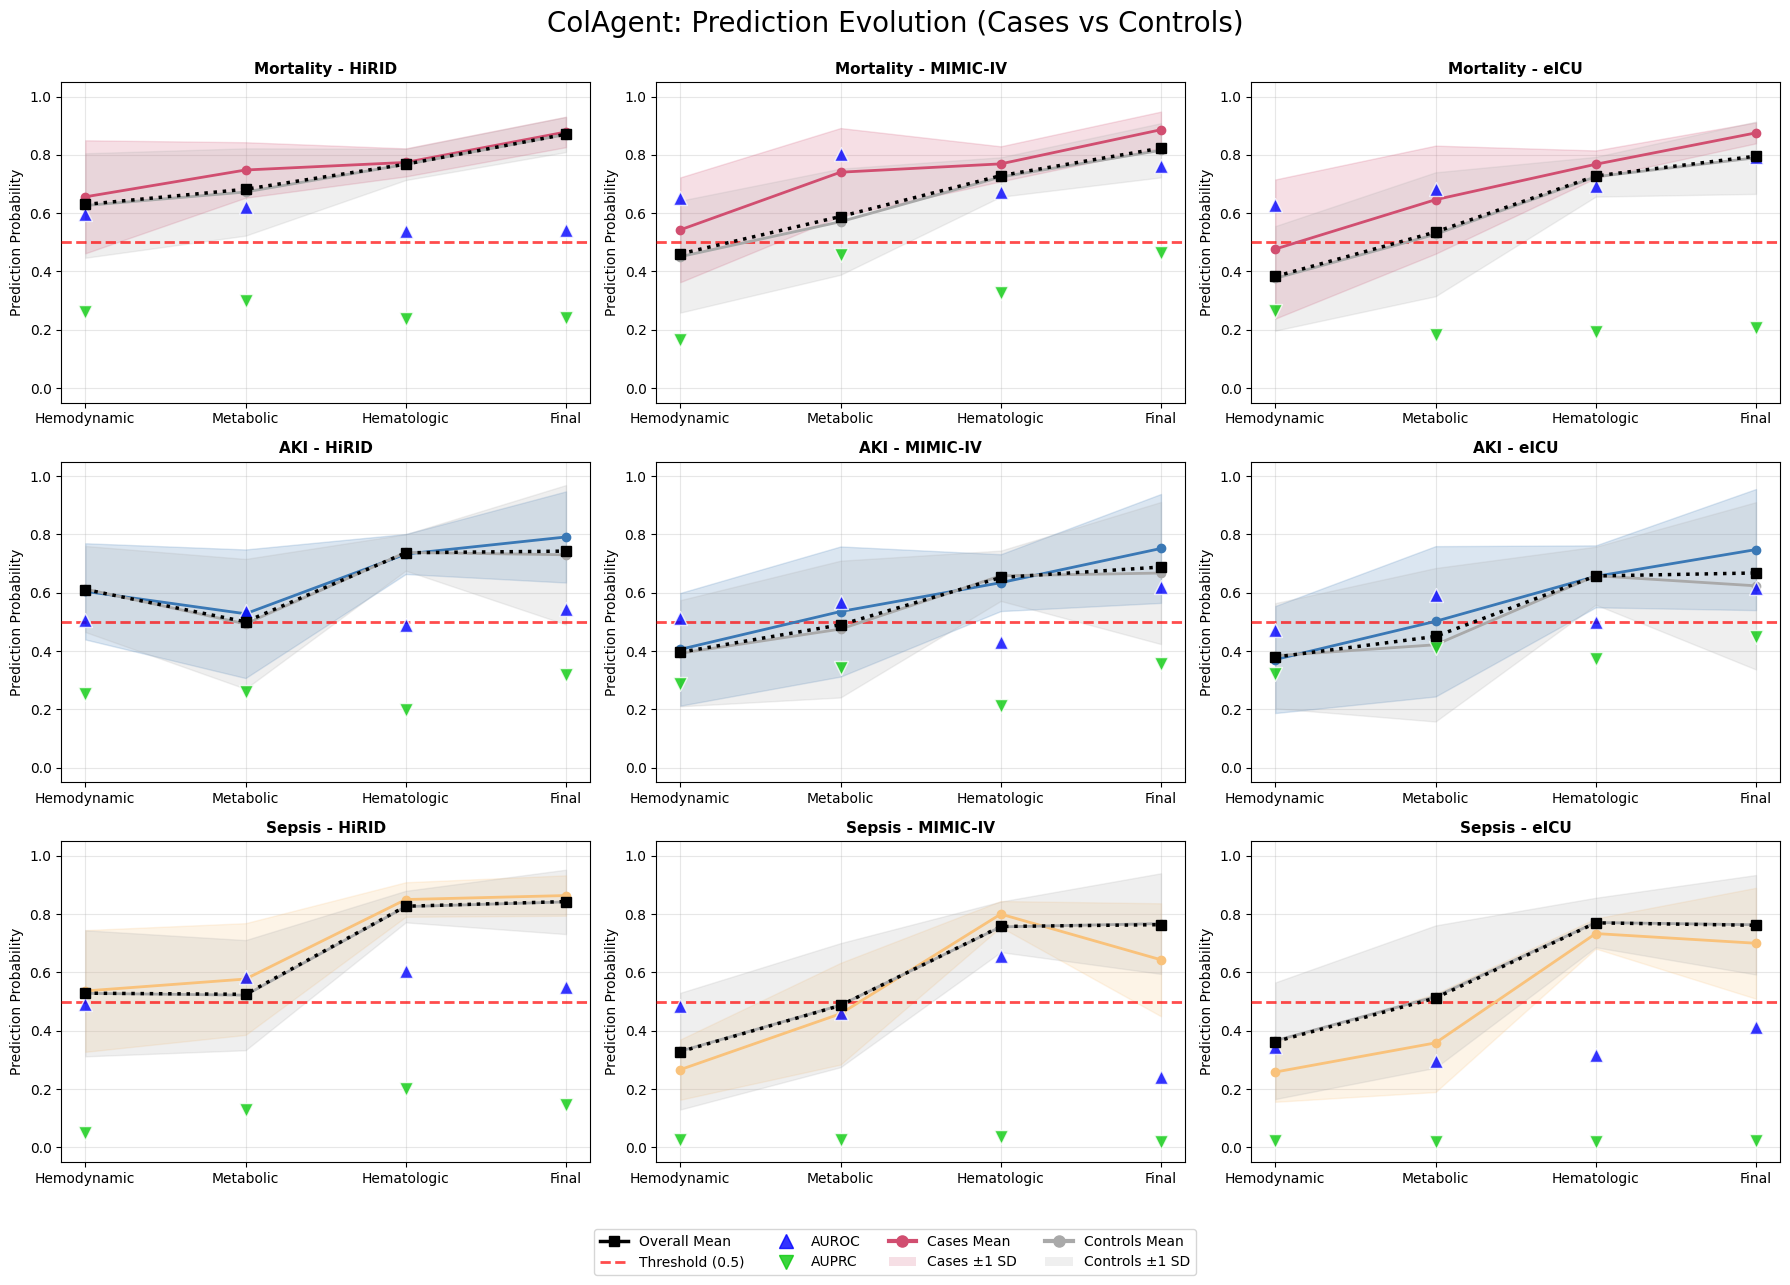


AUROC/AUPRC values for each subplot:
Mortality - HiRID:
  Hemodynamic: AUROC=0.597, AUPRC=0.262
  Metabolic: AUROC=0.622, AUPRC=0.298
  Hematologic: AUROC=0.539, AUPRC=0.236
  Final: AUROC=0.542, AUPRC=0.241
Mortality - MIMIC-IV:
  Hemodynamic: AUROC=0.651, AUPRC=0.164
  Metabolic: AUROC=0.803, AUPRC=0.458
  Hematologic: AUROC=0.672, AUPRC=0.326
  Final: AUROC=0.762, AUPRC=0.462
Mortality - eICU:
  Hemodynamic: AUROC=0.627, AUPRC=0.264
  Metabolic: AUROC=0.684, AUPRC=0.183
  Hematologic: AUROC=0.694, AUPRC=0.191
  Final: AUROC=0.792, AUPRC=0.207
AKI - HiRID:
  Hemodynamic: AUROC=0.507, AUPRC=0.254
  Metabolic: AUROC=0.538, AUPRC=0.261
  Hematologic: AUROC=0.489, AUPRC=0.196
  Final: AUROC=0.544, AUPRC=0.319
AKI - MIMIC-IV:
  Hemodynamic: AUROC=0.515, AUPRC=0.288
  Metabolic: AUROC=0.568, AUPRC=0.342
  Hematologic: AUROC=0.431, AUPRC=0.211
  Final: AUROC=0.621, AUPRC=0.354
AKI - eICU:
  Hemodynamic: AUROC=0.473, AUPRC=0.323
  Metabolic: AUROC=0.592, AUPRC=0.411
  Hematologic: AUROC=0.4

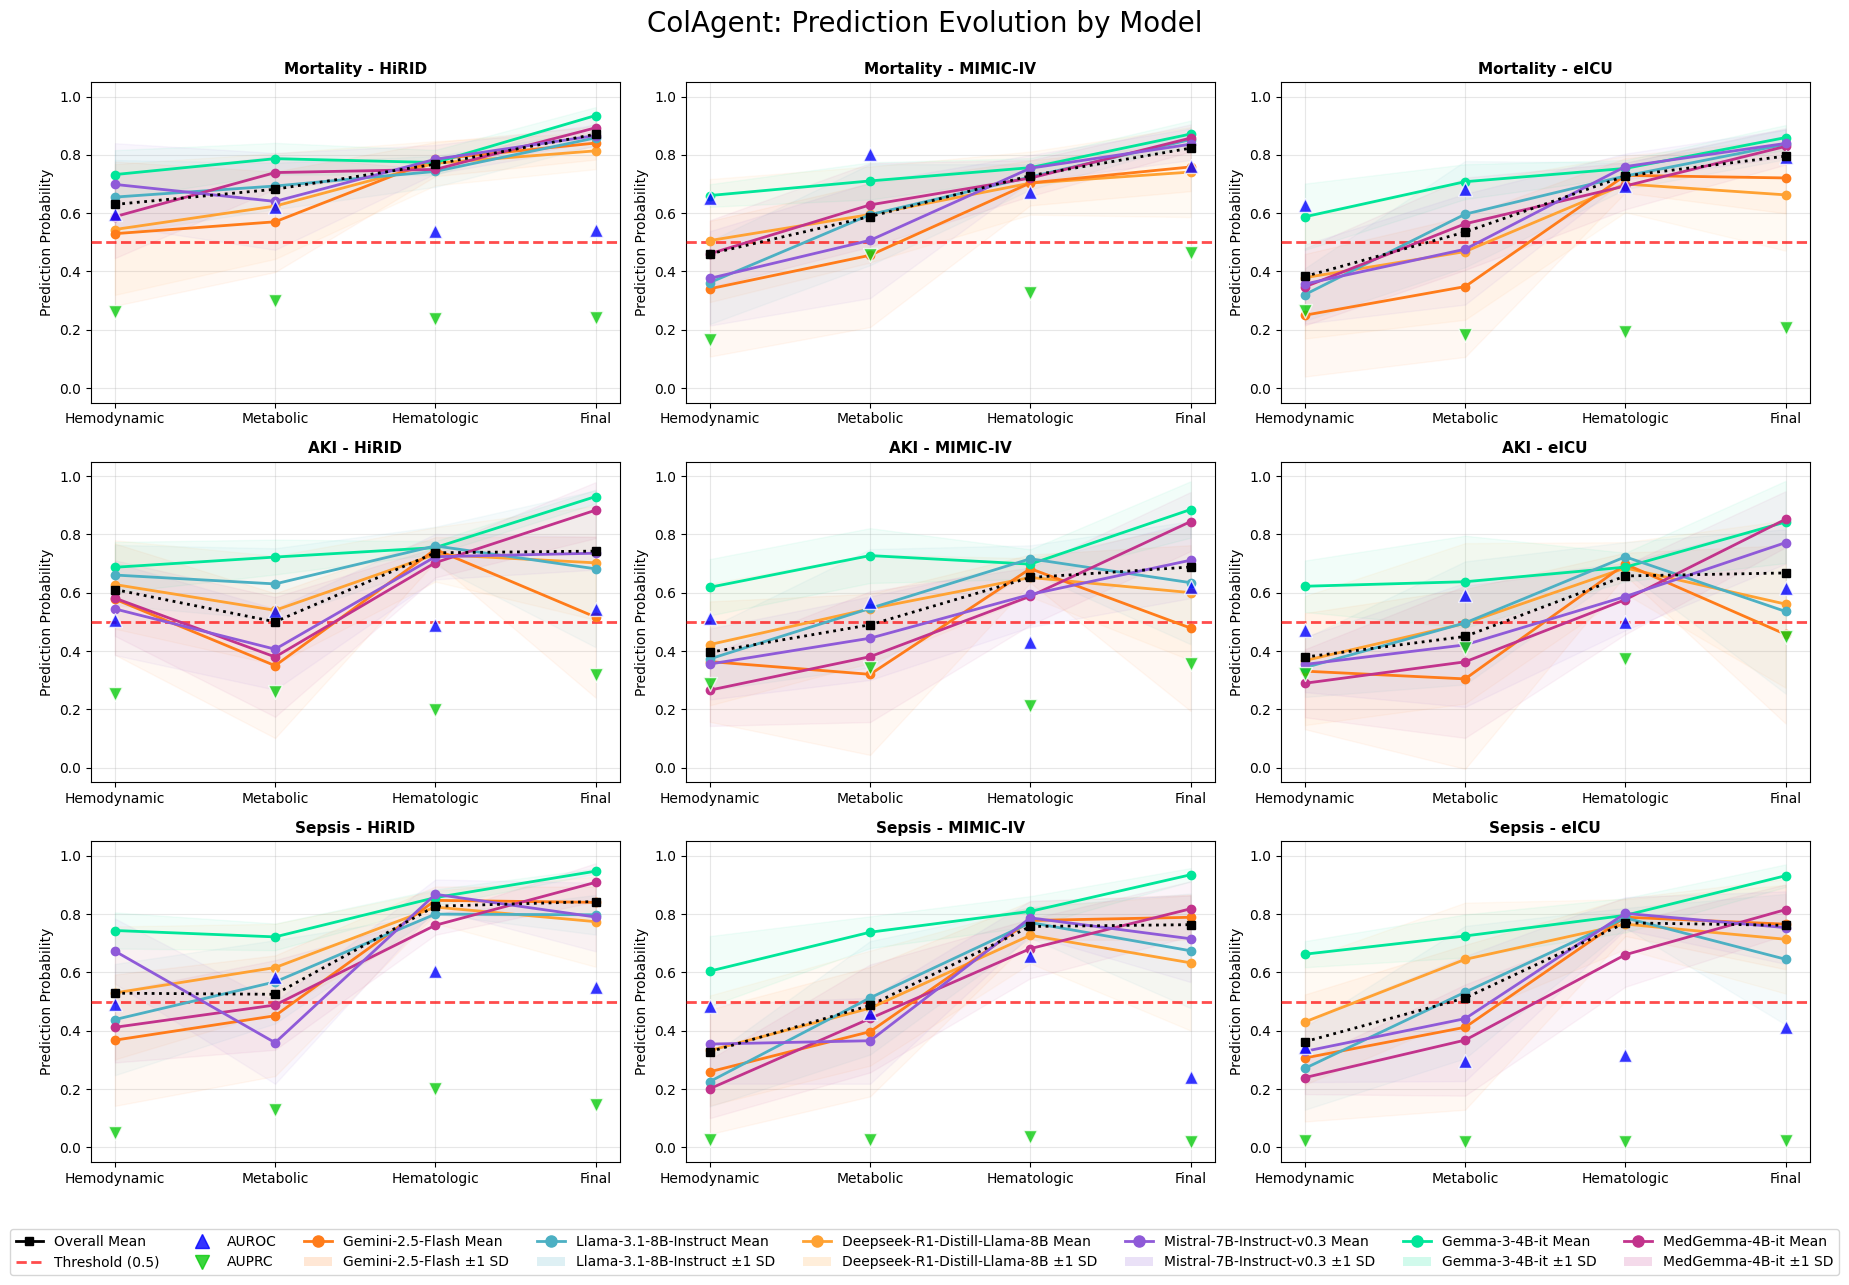


AUROC/AUPRC values for each subplot:
Mortality - HiRID:
  Hemodynamic: AUROC=0.597, AUPRC=0.262
  Metabolic: AUROC=0.622, AUPRC=0.298
  Hematologic: AUROC=0.539, AUPRC=0.236
  Final: AUROC=0.542, AUPRC=0.241
Mortality - MIMIC-IV:
  Hemodynamic: AUROC=0.651, AUPRC=0.164
  Metabolic: AUROC=0.803, AUPRC=0.458
  Hematologic: AUROC=0.672, AUPRC=0.326
  Final: AUROC=0.762, AUPRC=0.462
Mortality - eICU:
  Hemodynamic: AUROC=0.627, AUPRC=0.264
  Metabolic: AUROC=0.684, AUPRC=0.183
  Hematologic: AUROC=0.694, AUPRC=0.191
  Final: AUROC=0.792, AUPRC=0.207
AKI - HiRID:
  Hemodynamic: AUROC=0.507, AUPRC=0.254
  Metabolic: AUROC=0.538, AUPRC=0.261
  Hematologic: AUROC=0.489, AUPRC=0.196
  Final: AUROC=0.544, AUPRC=0.319
AKI - MIMIC-IV:
  Hemodynamic: AUROC=0.515, AUPRC=0.288
  Metabolic: AUROC=0.568, AUPRC=0.342
  Hematologic: AUROC=0.431, AUPRC=0.211
  Final: AUROC=0.621, AUPRC=0.354
AKI - eICU:
  Hemodynamic: AUROC=0.473, AUPRC=0.323
  Metabolic: AUROC=0.592, AUPRC=0.411
  Hematologic: AUROC=0.4

In [11]:
def create_prediction_evolution_plot_cra(
    view_type="cases_controls", models_to_include=None, save_suffix=""
):
    """
    Visualize prediction evolution across CRA agent steps using the sample-level dataframe.
    Steps: Hemodynamic, Metabolic, Hematologic, Final Prediction.
    Means are shown as lines; standard deviation fill is only shown for subgroups (cases/controls or models), not for overall mean.
    Legend is shown below the grid with 2 rows and open-end columns.
    Only the last row shows xticklabels; all subplots have both x and y axis grid.
    If models_to_include is set, only samples from those models are used (for both views).
    """

    # Use the step_pivot DataFrame created earlier
    step_labels = [
        "probabilities_Hemodynamic Assessment",
        "probabilities_Metabolic Assessment",
        "probabilities_Hematologic Assessment",
        "probabilities_Final Prediction",
    ]
    step_display_names = [
        "Hemodynamic",
        "Metabolic",
        "Hematologic",
        "Final",
    ]
    step_positions = list(range(len(step_labels)))

    plot_df = step_pivot.copy()
    if models_to_include is not None:
        if isinstance(models_to_include, str):
            models_to_include = [models_to_include]
        plot_df = plot_df[plot_df["model_name"].isin(models_to_include)]
        print(f"Filtered to models: {models_to_include}")

    # Only keep samples with initial and final prediction
    initial_col = step_labels[0]
    final_col = step_labels[-1]
    plot_df = plot_df[plot_df[initial_col].notna() & plot_df[final_col].notna()].copy()
    print(f"Samples with initial and final prediction: {len(plot_df):,}")

    tasks = ["Mortality", "AKI", "Sepsis"]
    datasets = ["HiRID", "MIMIC-IV", "eICU"]

    fig, axes = plt.subplots(3, 3, figsize=(18, 12))
    # Title logic: append models if models_to_include is set
    if view_type == "cases_controls":
        if models_to_include is not None:
            title = (
                "ColAgent: Prediction Evolution (Cases vs Controls) "
                f"({', '.join(models_to_include)})"
            )
        else:
            title = "ColAgent: Prediction Evolution (Cases vs Controls)"
    else:
        if models_to_include is not None:
            title = (
                "ColAgent: Prediction Evolution by Model "
                f"({', '.join(models_to_include)})"
            )
        else:
            title = "ColAgent: Prediction Evolution by Model"
    fig.suptitle(title, fontsize=20, y=0.98)

    legend_models = None
    if view_type == "models":
        if models_to_include is not None:
            legend_models = [m for m in LLM_MODELS if m in plot_df["model_name"].unique()]
        else:
            legend_models = [m for m in LLM_MODELS if m in plot_df["model_name"].unique()]

    # Collect legend elements for later
    legend_elements = []
    legend_cases_controls = [
        mlines.Line2D(
            [0],
            [0],
            color="black",
            linewidth=2.5,
            marker="s",
            markersize=7,
            label="Overall Mean",
        ),
        mlines.Line2D(
            [0],
            [0],
            color="red",
            linestyle="--",
            linewidth=2,
            alpha=0.7,
            label="Threshold (0.5)",
        ),
        mlines.Line2D(
            [0],
            [0],
            marker="^",
            color="blue",
            linestyle="None",
            markersize=10,
            alpha=0.8,
            label="AUROC",
        ),
        mlines.Line2D(
            [0],
            [0],
            marker="v",
            color="#09CB0C",
            linestyle="None",
            markersize=10,
            alpha=0.8,
            label="AUPRC",
        ),
        mlines.Line2D(
            [0],
            [0],
            color=TASK_MAPPING["mortality"][1]["case"],
            linewidth=3,
            marker="o",
            markersize=8,
            label="Cases Mean",
        ),
        Patch(
            facecolor=TASK_MAPPING["mortality"][1]["case"],
            alpha=0.18,
            label="Cases ±1 SD",
        ),
        mlines.Line2D(
            [0],
            [0],
            color="darkgray",
            linewidth=3,
            marker="o",
            markersize=8,
            label="Controls Mean",
        ),
        Patch(facecolor="darkgray", alpha=0.18, label="Controls ±1 SD"),
    ]
    legend_models_base = [
        mlines.Line2D(
            [0],
            [0],
            color="black",
            linewidth=2,
            marker="s",
            markersize=6,
            label="Overall Mean",
        ),
        mlines.Line2D(
            [0],
            [0],
            color="red",
            linestyle="--",
            linewidth=2,
            alpha=0.7,
            label="Threshold (0.5)",
        ),
        mlines.Line2D(
            [0],
            [0],
            marker="^",
            color="blue",
            linestyle="None",
            markersize=10,
            alpha=0.8,
            label="AUROC",
        ),
        mlines.Line2D(
            [0],
            [0],
            marker="v",
            color="#09CB0C",
            linestyle="None",
            markersize=10,
            alpha=0.8,
            label="AUPRC",
        ),
    ]

    if view_type == "cases_controls":
        legend_elements = legend_cases_controls
    else:
        legend_elements = legend_models_base.copy()
        for model in legend_models:
            model_color = get_model_color(model)
            legend_elements.append(
                mlines.Line2D(
                    [0],
                    [0],
                    color=model_color,
                    linewidth=2,
                    marker="o",
                    markersize=8,
                    label=f"{model} Mean",
                )
            )
            legend_elements.append(
                Patch(facecolor=model_color, alpha=0.18, label=f"{model} ±1 SD")
            )

    # Store all AUROC/AUPRC values for concise printing
    all_metrics = []

    for i, task in enumerate(tasks):
        for j, dataset in enumerate(datasets):
            ax = axes[i, j]
            task_data = plot_df[
                (plot_df["task"] == task) & (plot_df["dataset"] == dataset)
            ]
            if len(task_data) == 0:
                ax.text(
                    0.5,
                    0.5,
                    f"No data for\n{task}-{dataset}",
                    ha="center",
                    va="center",
                    transform=ax.transAxes,
                    fontsize=12,
                )
                ax.set_title(f"{task} - {dataset}", fontsize=14, fontweight="bold")
                continue
            plot_data = (
                task_data.sample(n=200, random_state=42)
                if len(task_data) > 200
                else task_data
            )

            # Plot means and standard deviations for each subgroup
            if view_type == "cases_controls":
                controls = plot_data[plot_data["label"] == 0]
                cases = plot_data[plot_data["label"] == 1]
                for group, group_color, label, alpha_fill in [
                    (cases, TASK_MAPPING[task.lower()][1]["case"], "Cases Mean", 0.18),
                    (controls, "darkgray", "Controls Mean", 0.18),
                ]:
                    means, stds, valid_positions = [], [], []
                    for pos, col in enumerate(step_labels):
                        vals = pd.to_numeric(group[col], errors="coerce")
                        mean_val = vals.mean()
                        std_val = vals.std()
                        if not np.isnan(mean_val):
                            means.append(mean_val)
                            stds.append(std_val)
                            valid_positions.append(pos)
                    ax.plot(
                        valid_positions,
                        means,
                        color=group_color,
                        linewidth=2,
                        marker="o",
                        markersize=6,
                        label=label,
                        zorder=6,
                    )
                    ax.fill_between(
                        valid_positions,
                        np.array(means) - np.array(stds),
                        np.array(means) + np.array(stds),
                        color=group_color,
                        alpha=alpha_fill,
                        zorder=5,
                        label=f"{label} ±1 SD",
                    )
                # Overall mean (no SD fill)
                means, valid_positions = [], []
                for pos, col in enumerate(step_labels):
                    mean_val = pd.to_numeric(plot_data[col], errors="coerce").mean()
                    if not np.isnan(mean_val):
                        means.append(mean_val)
                        valid_positions.append(pos)
                ax.plot(
                    valid_positions,
                    means,
                    color="black",
                    linewidth=2.5,
                    marker="s",
                    markersize=7,
                    label="Overall Mean",
                    zorder=10,
                    linestyle=":",
                )
                ax.axhline(
                    y=0.5,
                    color="red",
                    linestyle="--",
                    alpha=0.7,
                    linewidth=2,
                    label="Classification Threshold (0.5)",
                    zorder=5,
                )
            else:
                if models_to_include is not None:
                    models = [
                        m for m in models_to_include if m in plot_data["model_name"].unique()
                    ]
                else:
                    models = sorted(plot_data["model_name"].unique())
                for idx, model in enumerate(models):
                    model_data = plot_data[plot_data["model_name"] == model]
                    means, stds, valid_positions = [], [], []
                    for pos, col in enumerate(step_labels):
                        vals = pd.to_numeric(model_data[col], errors="coerce")
                        mean_val = vals.mean()
                        std_val = vals.std()
                        if not np.isnan(mean_val):
                            means.append(mean_val)
                            stds.append(std_val)
                            valid_positions.append(pos)
                    model_color = get_model_color(model)
                    ax.plot(
                        valid_positions,
                        means,
                        color=model_color,
                        linewidth=2,
                        marker="o",
                        markersize=6,
                        label=f"{model} Mean",
                        zorder=6,
                    )
                    ax.fill_between(
                        valid_positions,
                        np.array(means) - np.array(stds),
                        np.array(means) + np.array(stds),
                        color=model_color,
                        alpha=0.05,
                        zorder=5,
                        label=f"{model} ±1 SD",
                    )
                # Overall mean (no SD fill)
                means, valid_positions = [], []
                for pos, col in enumerate(step_labels):
                    mean_val = pd.to_numeric(plot_data[col], errors="coerce").mean()
                    if not np.isnan(mean_val):
                        means.append(mean_val)
                        valid_positions.append(pos)
                ax.plot(
                    valid_positions,
                    means,
                    color="black",
                    linewidth=2,
                    marker="s",
                    markersize=6,
                    label="Overall Mean",
                    zorder=10,
                    linestyle=":",
                )
                ax.axhline(
                    y=0.5,
                    color="red",
                    linestyle="--",
                    alpha=0.7,
                    linewidth=2,
                    label="Classification Threshold (0.5)",
                    zorder=5,
                )

            # AUROC/AUPRC for each step (skip missing)
            step_metrics = []
            for pos, col in enumerate(step_labels):
                y_true = plot_data["label"].values
                y_pred = pd.to_numeric(plot_data[col], errors="coerce").values
                mask = ~np.isnan(y_pred)
                if mask.sum() < 2 or len(np.unique(y_true[mask])) < 2:
                    step_metrics.append((pos, None, None))
                    continue
                try:
                    auroc = roc_auc_score(y_true[mask], y_pred[mask])
                    precision, recall, _ = precision_recall_curve(
                        y_true[mask], y_pred[mask]
                    )
                    auprc = auc(recall, precision)
                    ax.scatter(
                        pos,
                        auroc,
                        marker="^",
                        s=100,
                        color="blue",
                        alpha=0.8,
                        zorder=8,
                        edgecolors="white",
                        linewidth=1,
                    )
                    ax.scatter(
                        pos,
                        auprc,
                        marker="v",
                        s=100,
                        color="#09CB0C",
                        alpha=0.8,
                        zorder=8,
                        edgecolors="white",
                        linewidth=1,
                    )
                    step_metrics.append((pos, auroc, auprc))
                except Exception:
                    step_metrics.append((pos, None, None))
                    continue

            # Store metrics for concise printing
            all_metrics.append(
                {
                    "task": task,
                    "dataset": dataset,
                    "metrics": [
                        {
                            "step": step_display_names[pos],
                            "auroc": auroc,
                            "auprc": auprc,
                        }
                        for pos, auroc, auprc in step_metrics
                    ],
                }
            )

            ax.set_ylim(-0.05, 1.05)
            ax.set_ylabel("Prediction Probability", fontsize=10)
            ax.set_title(f"{task} - {dataset}", fontsize=11, fontweight="bold")
            ax.grid(True, alpha=0.3, axis="both")
            # Show xticks for all rows, but only show xticklabels for last row
            ax.set_xticks(step_positions)
            ax.set_xticklabels(
                    step_display_names, fontsize=10, rotation=0,
                )
            # if i == len(tasks) - 1:
            #     ax.set_xticklabels(
            #         step_display_names, fontsize=10, rotation=0,# ha="right"
            #     )
            # else:
            #     ax.set_xticklabels([""] * len(step_positions))

    # Place legend below the grid, split into 2 rows and open columns
    fig.legend(
        handles=legend_elements,
        loc="lower center",
        bbox_to_anchor=(0.5, -0.08),
        fontsize=10,
        frameon=True,
        ncol=int(np.ceil(len(legend_elements) / 2)),
    )

    plt.tight_layout()
    plt.subplots_adjust(top=0.92, bottom=0.02)
    if view_type == "cases_controls":
        save_path = os.path.join(
            OUTPUT_BASE_DIR, f"cra_prediction_evolution_cases_controls{save_suffix}.png"
        )
    else:
        model_suffix = (
            f"_{'_'.join(models_to_include)}" if models_to_include else "_all_models"
        )
        save_path = os.path.join(
            OUTPUT_BASE_DIR,
            f"cra_prediction_evolution_models{model_suffix}{save_suffix}.png",
        )
    plt.savefig(save_path, dpi=400, bbox_inches="tight")
    print(f"Prediction evolution plot saved to: {save_path}")
    plt.show()
    # Concise printing of AUROC/AUPRC values
    print("\nAUROC/AUPRC values for each subplot:")
    for entry in all_metrics:
        print(f"{entry['task']} - {entry['dataset']}:")
        for metric in entry["metrics"]:
            if metric["auroc"] is not None and metric["auprc"] is not None:
                print(
                    f"  {metric['step']}: AUROC={metric['auroc']:.3f}, AUPRC={metric['auprc']:.3f}"
                )
            else:
                print(f"  {metric['step']}: AUROC=NA, AUPRC=NA")

    return fig

# Create prediction evolution plots

# 1. Original cases vs controls view (default)
print("Creating cases vs controls view...")
evolution_fig_cases = create_prediction_evolution_plot_cra(
    models_to_include=None
)
# evolution_fig_cases = create_prediction_evolution_plot_cra(
#     models_to_include=["Gemini-2.5-Flash"], save_suffix="_cases_controls_gemini2p5flash"
# )

# 2. Models view with all models
print("\nCreating models view with all models...")
evolution_fig_models_all = create_prediction_evolution_plot_cra(view_type="models")

# # 3. Models view with specific models
# # First, let's see what models are available
# available_models = step_pivot["model_name"].unique()
# print(f"\nAvailable models: {list(available_models)}")

# print(f"\nCreating models view with selected models")
# step_by_step_selected_models = [
#     "Gemini-2.5-Flash",
#     "Llama-3.1-8B-Instruct",
#     # "Mistral-7B-Instruct-v0.3",
# ]
# evolution_fig_models_selected = create_prediction_evolution_plot_cra(
#     view_type="models",
#     models_to_include=step_by_step_selected_models,
#     save_suffix=f"_selected",  # Example suffix for saved file    ,
# )

In [12]:
# --- Aggregated Insights: Specialist, Model, and Task Performance (no bootstrapping, no SDs) ---

def compute_metrics(y_true, y_pred):
    """Compute AUROC and AUPRC (no bootstrapping, no SDs)."""
    mask = ~pd.isna(y_pred)
    y_true = np.array(y_true)[mask]
    y_pred = np.array(y_pred)[mask]
    if len(y_true) < 2 or len(np.unique(y_true)) < 2:
        return (np.nan, np.nan)
    try:
        auroc = roc_auc_score(y_true, y_pred)
        auprc = average_precision_score(y_true, y_pred)
    except Exception:
        return (np.nan, np.nan)
    return (auroc, auprc)


specialist_steps = [
    "probabilities_Hemodynamic Assessment",
    "probabilities_Metabolic Assessment",
    "probabilities_Hematologic Assessment",
]
step_display_names = ["Hemodynamic", "Metabolic", "Hematologic"]

# 1. Specialist agent performance (overall)
print("\n=== Specialist Agent Performance (Overall) ===")
overall_specialist_results = []
for step, name in zip(specialist_steps, step_display_names):
    auroc, auprc = compute_metrics(step_pivot["label"], step_pivot[step])
    overall_specialist_results.append((name, auroc, auprc))
    print(f"{name}: AUROC={auroc:.3f}, AUPRC={auprc:.3f}")

# 2. Specialist agent performance (per task)
print("\n=== Specialist Agent Performance (Per Task) ===")
best_specialist_per_task = []
for task in step_pivot["task"].unique():
    print(f"\nTask: {task}")
    task_results = []
    for step, name in zip(specialist_steps, step_display_names):
        mask = step_pivot["task"] == task
        auroc, auprc = compute_metrics(
            step_pivot.loc[mask, "label"], step_pivot.loc[mask, step]
        )
        task_results.append((name, auroc, auprc))
        print(f"  {name}: AUROC={auroc:.3f}, AUPRC={auprc:.3f}")
    # Find best specialist for this task (by AUROC)
    best = max(task_results, key=lambda x: (x[1] if not np.isnan(x[1]) else -1))
    best_specialist_per_task.append((task, best[0], best[1], best[2]))
    print(
        f"  -> Best specialist for {task}: {best[0]} (AUROC={best[1]:.3f}, AUPRC={best[2]:.3f})"
    )

# 3. Best specialist overall (by AUROC)
best_overall = max(
    overall_specialist_results, key=lambda x: (x[1] if not np.isnan(x[1]) else -1)
)
print(
    f"\nBest specialist overall: {best_overall[0]} (AUROC={best_overall[1]:.3f}, AUPRC={best_overall[2]:.3f})"
)

# 4. Model performance (final prediction, overall)
print("\n=== Model Performance (Final Prediction, Overall) ===")
model_scores = []
for model in step_pivot["model_name"].unique():
    mask = step_pivot["model_name"] == model
    auroc, auprc = compute_metrics(
        step_pivot.loc[mask, "label"],
        step_pivot.loc[mask, "probabilities_Final Prediction"],
    )
    model_scores.append((model, auroc, auprc))
    print(f"{model}: AUROC={auroc:.3f}, AUPRC={auprc:.3f}")

best_model = max(model_scores, key=lambda x: (x[1] if not np.isnan(x[1]) else -1))
print(
    f"\nBest model overall (by AUROC): {best_model[0]} (AUROC={best_model[1]:.3f}, AUPRC={best_model[2]:.3f})"
)

# 5. Task performance (final prediction, all models)
print("\n=== Task Performance (Final Prediction, All Models) ===")
task_scores = []
for task in step_pivot["task"].unique():
    mask = step_pivot["task"] == task
    auroc, auprc = compute_metrics(
        step_pivot.loc[mask, "label"],
        step_pivot.loc[mask, "probabilities_Final Prediction"],
    )
    task_scores.append((task, auroc, auprc))
    print(f"{task}: AUROC={auroc:.3f}, AUPRC={auprc:.3f}")

best_task = max(task_scores, key=lambda x: (x[1] if not np.isnan(x[1]) else -1))
print(
    f"\nBest task overall (by AUROC): {best_task[0]} (AUROC={best_task[1]:.3f}, AUPRC={best_task[2]:.3f})"
)

# --- Actionable Insights for Paper ---
print("\n=== Actionable Insights for ColAgent Paper ===")
print(
    f"- The best overall specialist agent is {best_overall[0]}, achieving AUROC={best_overall[1]:.3f} and AUPRC={best_overall[2]:.3f} across all tasks."
)
for task, name, auroc, auprc in best_specialist_per_task:
    print(
        f"- For the task '{task}', the best specialist is {name} (AUROC={auroc:.3f}, AUPRC={auprc:.3f})."
    )
print(
    f"- The best performing model for the final prediction is {best_model[0]} (AUROC={best_model[1]:.3f}, AUPRC={best_model[2]:.3f})."
)
print(
    f"- The task with the highest overall performance is {best_task[0]} (AUROC={best_task[1]:.3f}, AUPRC={best_task[2]:.3f})."
)
print(
    "- Standard deviations are not reported; metrics are computed on the full available data."
)
print(
    "- These results highlight which specialist and model configurations are most robust and reliable for the ColAgent across tasks."
)

# --- Cases vs Controls: Mean and SD of Predicted Probabilities at Each Step ---

print("\n=== Cases vs Controls: Mean ± SD of Predicted Probabilities at Each Step ===")
for step, name in zip(specialist_steps + ["probabilities_Final Prediction"], step_display_names + ["Final"]):
    cases = step_pivot.loc[step_pivot["label"] == 1, step]
    controls = step_pivot.loc[step_pivot["label"] == 0, step]
    mean_cases = np.nanmean(cases)
    std_cases = np.nanstd(cases)
    mean_controls = np.nanmean(controls)
    std_controls = np.nanstd(controls)
    print(f"{name}:")
    print(f"  Cases   : Mean={mean_cases:.3f} ± {std_cases:.3f} (n={cases.notna().sum()})")
    print(f"  Controls: Mean={mean_controls:.3f} ± {std_controls:.3f} (n={controls.notna().sum()})")


=== Specialist Agent Performance (Overall) ===
Hemodynamic: AUROC=nan, AUPRC=nan
Metabolic: AUROC=nan, AUPRC=nan
Hematologic: AUROC=nan, AUPRC=nan

=== Specialist Agent Performance (Per Task) ===

Task: AKI
  Hemodynamic: AUROC=nan, AUPRC=nan
  Metabolic: AUROC=nan, AUPRC=nan
  Hematologic: AUROC=nan, AUPRC=nan
  -> Best specialist for AKI: Hemodynamic (AUROC=nan, AUPRC=nan)

Task: Mortality
  Hemodynamic: AUROC=nan, AUPRC=nan
  Metabolic: AUROC=nan, AUPRC=nan
  Hematologic: AUROC=nan, AUPRC=nan
  -> Best specialist for Mortality: Hemodynamic (AUROC=nan, AUPRC=nan)

Task: Sepsis
  Hemodynamic: AUROC=nan, AUPRC=nan
  Metabolic: AUROC=nan, AUPRC=nan
  Hematologic: AUROC=nan, AUPRC=nan
  -> Best specialist for Sepsis: Hemodynamic (AUROC=nan, AUPRC=nan)

Best specialist overall: Hemodynamic (AUROC=nan, AUPRC=nan)

=== Model Performance (Final Prediction, Overall) ===
Deepseek-R1-Distill-Llama-8B: AUROC=nan, AUPRC=nan
Gemini-2.5-Flash: AUROC=nan, AUPRC=nan
Gemma-3-4B-it: AUROC=nan, AUPRC=n

## 4. Synthesis Quality Analysis

This section analyzes how well the agent synthesizes information in the final step (confidence weighted synthesis)


SYNTHESIS QUALITY ANALYSIS (CRA Agent)
Samples with complete synthesis data: 37,020
Synthesis quality plot saved to: ./notebook_output/pulse_agents_colagent/cra_synthesis_quality.png


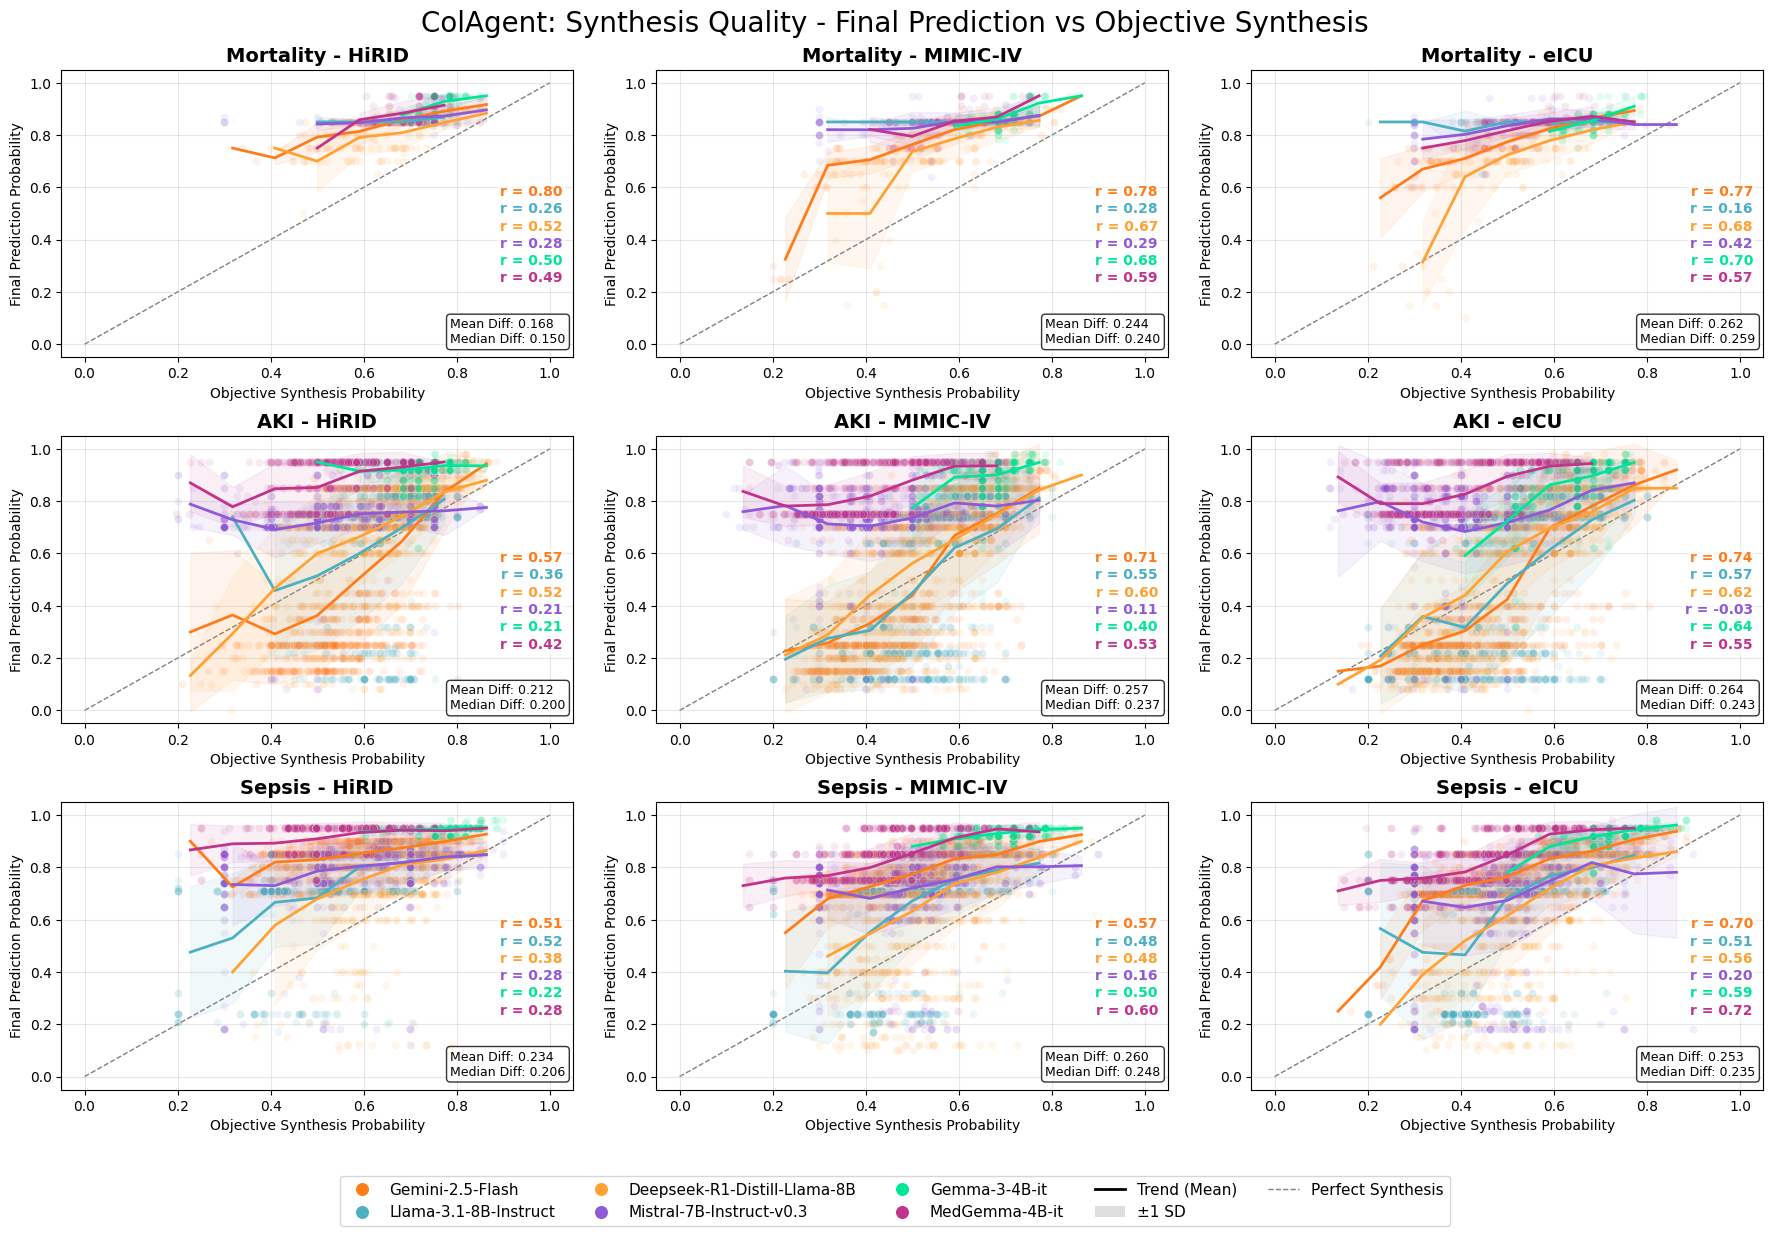

In [18]:
# --- Synthesis Quality Analysis: CRA Agent (Improved Visualization) ---

print("\n" + "=" * 80)
print("SYNTHESIS QUALITY ANALYSIS (CRA Agent)")
print("=" * 80)


def convert_to_numeric_safe(series, default_value=0.0):
    """Safely convert a series to numeric, handling mixed types."""
    if series.dtype == "object":
        numeric_series = pd.to_numeric(series, errors="coerce")
        return numeric_series.fillna(default_value)
    elif pd.api.types.is_numeric_dtype(series):
        return series.fillna(default_value)
    else:
        try:
            return pd.to_numeric(series, errors="coerce").fillna(default_value)
        except:
            return pd.Series([default_value] * len(series), index=series.index)


def create_cra_synthesis_quality_plot(models=None, save_suffix=""):
    """
    Visualize synthesis quality: Final Prediction vs. Objective Synthesis (confidence-weighted specialist probabilities).
    Shows per-model scatter, trend line with std, and correlation, stratified by task and dataset (3x3 grid).
    """

    # Prepare data: compute objective synthesis if not present
    def compute_objective_synthesis(row):
        probs, confs = [], []
        for step in [
            "Hemodynamic Assessment",
            "Metabolic Assessment",
            "Hematologic Assessment",
        ]:
            p = row.get(f"probabilities_{step}", np.nan)
            c = row.get(f"Confidence_numeric_{step}", np.nan)
            if pd.notna(p) and pd.notna(c):
                if c > 1.01:
                    c = c / 100.0
                probs.append(p)
                confs.append(c)
        if len(probs) == 0 or sum(confs) == 0:
            return np.nan
        return np.average(probs, weights=confs)

    # Add objective synthesis column if not present
    if "objective_synthesis" not in step_pivot.columns:
        step_pivot["objective_synthesis"] = step_pivot.apply(
            compute_objective_synthesis, axis=1
        )

    # Prepare synthesis_data DataFrame
    synthesis_data = step_pivot[
        step_pivot["probabilities_Final Prediction"].notna()
        & step_pivot["objective_synthesis"].notna()
    ].copy()

    # Model filtering and ordering
    if models is not None:
        ordered_models = [m for m in LLM_MODELS if m in models]
        synthesis_data = synthesis_data[
            synthesis_data["model_name"].isin(ordered_models)
        ]
        synthesis_data["model_name"] = pd.Categorical(
            synthesis_data["model_name"], categories=ordered_models, ordered=True
        )
    else:
        ordered_models = [
            m for m in LLM_MODELS if m in synthesis_data["model_name"].unique()
        ]

    # Convert columns to numeric
    synthesis_data["final_prediction_numeric"] = convert_to_numeric_safe(
        synthesis_data["probabilities_Final Prediction"]
    )
    synthesis_data["objective_synthesis_numeric"] = convert_to_numeric_safe(
        synthesis_data["objective_synthesis"]
    )

    print(f"Samples with complete synthesis data: {len(synthesis_data):,}")

    tasks = ["Mortality", "AKI", "Sepsis"]
    datasets = ["HiRID", "MIMIC-IV", "eICU"]

    fig, axes = plt.subplots(3, 3, figsize=(18, 12))

    # Title
    if models is not None:
        title = f"ColAgent: Synthesis Quality - Final Prediction vs Objective Synthesis ({', '.join(models)})"
    else:
        title = "ColAgent: Synthesis Quality - Final Prediction vs Objective Synthesis"
    fig.suptitle(title, fontsize=20, y=0.98)

    # Legend elements (LLM_MODELS order)
    legend_elements = []
    for model in ordered_models:
        color = get_model_color(model)
        legend_elements.append(
            mlines.Line2D(
                [0],
                [0],
                marker="o",
                color="w",
                markerfacecolor=color,
                markeredgecolor="white",
                markersize=8,
                label=model,
                alpha=1,
            )
        )
    # Trend line
    legend_elements.append(
        mlines.Line2D(
            [0], [0], color="black", linewidth=2, label="Trend (Mean)", alpha=1
        )
    )
    # Std fill
    legend_elements.append(Patch(facecolor="black", alpha=0.13, label="±1 SD"))
    # Diagonal
    legend_elements.append(
        mlines.Line2D(
            [0],
            [0],
            color="k",
            linestyle="--",
            linewidth=1,
            label="Perfect Synthesis",
            alpha=0.5,
        )
    )

    for i, task in enumerate(tasks):
        for j, dataset in enumerate(datasets):
            ax = axes[i, j]
            task_data = synthesis_data[
                (synthesis_data["task"] == task)
                & (synthesis_data["dataset"] == dataset)
            ]
            if len(task_data) == 0:
                ax.text(
                    0.5,
                    0.5,
                    f"No data for\n{task}-{dataset}",
                    ha="center",
                    va="center",
                    transform=ax.transAxes,
                    fontsize=12,
                )
                ax.set_title(f"{task} - {dataset}", fontsize=14, fontweight="bold")
                continue

            for model in [
                m for m in LLM_MODELS if m in task_data["model_name"].unique()
            ]:
                model_data = task_data[task_data["model_name"] == model]
                color = get_model_color(model)
                # Scatter points (transparent)
                ax.scatter(
                    model_data["objective_synthesis_numeric"],
                    model_data["final_prediction_numeric"],
                    c=color,
                    edgecolors="white",
                    linewidth=0.5,
                    alpha=0.10,
                    s=32,
                    label=None,
                    zorder=2,
                )
                # Trend line with std fill
                if len(model_data) > 10:
                    x = model_data["objective_synthesis_numeric"]
                    y = model_data["final_prediction_numeric"]
                    bins = np.linspace(0, 1, 12)
                    bin_centers = (bins[:-1] + bins[1:]) / 2
                    means, stds = [], []
                    for k in range(len(bins) - 1):
                        mask = (x >= bins[k]) & (x < bins[k + 1])
                        y_bin = y[mask]
                        if len(y_bin) > 0:
                            means.append(y_bin.mean())
                            stds.append(y_bin.std())
                        else:
                            means.append(np.nan)
                            stds.append(np.nan)
                    ax.plot(bin_centers, means, color=color, linewidth=2, zorder=4)
                    ax.fill_between(
                        bin_centers,
                        np.array(means) - np.array(stds),
                        np.array(means) + np.array(stds),
                        color=color,
                        alpha=0.08,
                        zorder=3,
                    )
                # Correlation annotation (right, stacked by model index)
                if len(model_data) > 10:
                    x = model_data["objective_synthesis_numeric"]
                    y = model_data["final_prediction_numeric"]
                    mask = x.notna() & y.notna()
                    if mask.sum() > 10:
                        corr = np.corrcoef(x[mask], y[mask])[0, 1]
                        model_idx = [
                            m
                            for m in LLM_MODELS
                            if m in task_data["model_name"].unique()
                        ].index(model)
                        ax.text(
                            0.98,
                            0.60 - 0.06 * model_idx,
                            f"r = {corr:.2f}",
                            transform=ax.transAxes,
                            fontsize=10,
                            fontweight="bold",
                            color=color,
                            ha="right",
                            va="top",
                            bbox=dict(
                                facecolor="white",
                                alpha=0.7,
                                edgecolor="none",
                                boxstyle="round,pad=0.2",
                            ),
                            zorder=10,
                        )

            # Diagonal line (perfect synthesis)
            ax.plot(
                [0, 1],
                [0, 1],
                "k--",
                alpha=0.5,
                linewidth=1,
                label="Perfect Synthesis",
                zorder=1,
            )

            # Formatting
            ax.set_xlim(-0.05, 1.05)
            ax.set_ylim(-0.05, 1.05)
            ax.set_xticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.0])
            ax.set_xticklabels(
                [f"{x:.1f}" for x in [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]], fontsize=10
            )
            ax.set_xlabel("Objective Synthesis Probability", fontsize=10)
            ax.set_ylabel("Final Prediction Probability", fontsize=10)
            ax.set_title(f"{task} - {dataset}", fontsize=14, fontweight="bold")
            ax.grid(True, alpha=0.3)

            # Synthesis agreement stats
            synthesis_diff = abs(
                task_data["final_prediction_numeric"]
                - task_data["objective_synthesis_numeric"]
            )
            mean_diff = synthesis_diff.mean()
            median_diff = synthesis_diff.median()
            ax.text(
                0.76,
                0.05,
                f"Mean Diff: {mean_diff:.3f}\nMedian Diff: {median_diff:.3f}",
                transform=ax.transAxes,
                fontsize=9,
                bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8),
            )

    # Legend below grid
    fig.legend(
        handles=legend_elements,
        loc="lower center",
        bbox_to_anchor=(0.5, -0.04),
        fontsize=11,
        frameon=True,
        ncol=min(5, len(legend_elements)),
        markerscale=1.3,
    )

    plt.tight_layout()
    plt.subplots_adjust(top=0.93, bottom=0.08)
    model_suffix = f"_{'_'.join(models)}" if models else ""
    save_path = os.path.join(
        OUTPUT_BASE_DIR, f"cra_synthesis_quality{model_suffix}{save_suffix}.png"
    )
    plt.savefig(save_path, dpi=400, bbox_inches="tight")
    print(f"Synthesis quality plot saved to: {save_path}")
    plt.show()
    return fig


# Example usage:
# selected_models = [
#     "Gemini-2.5-Flash",
#     "Llama-3.1-8B-Instruct",
#     "Mistral-7B-Instruct-v0.3",
# ]
synthesis_quality_fig = create_cra_synthesis_quality_plot(models=None)

In [15]:
# --- Synthesis Analysis Summary: Mean Differences, SDs, and Correlations (with explanations & insights) ---

print("\n" + "=" * 80)
print("SYNTHESIS QUALITY SUMMARY (Mean Diff, SD, Correlation) by Task and Model")
print("=" * 80)


# Prepare synthesis data (reuse logic from visualization)
def compute_objective_synthesis(row):
    probs, confs = [], []
    for step in [
        "Hemodynamic Assessment",
        "Metabolic Assessment",
        "Hematologic Assessment",
    ]:
        p = row.get(f"probabilities_{step}", np.nan)
        c = row.get(f"Confidence_numeric_{step}", np.nan)
        if pd.notna(p) and pd.notna(c):
            if c > 1.01:
                c = c / 100.0
            probs.append(p)
            confs.append(c)
    if len(probs) == 0 or sum(confs) == 0:
        return np.nan
    return np.average(probs, weights=confs)


if "objective_synthesis" not in step_pivot.columns:
    step_pivot["objective_synthesis"] = step_pivot.apply(
        compute_objective_synthesis, axis=1
    )

synthesis_data = step_pivot[
    step_pivot["probabilities_Final Prediction"].notna()
    & step_pivot["objective_synthesis"].notna()
].copy()

synthesis_data["final_prediction_numeric"] = pd.to_numeric(
    synthesis_data["probabilities_Final Prediction"], errors="coerce"
)
synthesis_data["objective_synthesis_numeric"] = pd.to_numeric(
    synthesis_data["objective_synthesis"], errors="coerce"
)

tasks = ["Mortality", "AKI", "Sepsis"]
models = [m for m in LLM_MODELS if m in synthesis_data["model_name"].unique()]

summary_rows = []

for task in tasks:
    for model in models:
        df = synthesis_data[
            (synthesis_data["task"] == task) & (synthesis_data["model_name"] == model)
        ]
        if len(df) == 0:
            continue
        diff = (
            df["final_prediction_numeric"] - df["objective_synthesis_numeric"]
        ).abs()
        mean_diff = diff.mean()
        std_diff = diff.std()
        # Correlation
        mask = (
            df["final_prediction_numeric"].notna()
            & df["objective_synthesis_numeric"].notna()
        )
        if mask.sum() > 2:
            corr = np.corrcoef(
                df.loc[mask, "final_prediction_numeric"],
                df.loc[mask, "objective_synthesis_numeric"],
            )[0, 1]
        else:
            corr = np.nan
        summary_rows.append(
            {
                "Task": task,
                "Model": model,
                "Mean Diff": mean_diff,
                "SD Diff": std_diff,
                "Correlation": corr,
            }
        )

summary_df = pd.DataFrame(summary_rows)

if not summary_df.empty:
    print("\nSYNTHESIS QUALITY BY TASK AND MODEL (sorted by mean diff):")
    print(
        summary_df.sort_values(["Task", "Mean Diff"]).to_string(
            index=False, float_format="%.3f"
        )
    )

    print("\nBest and worst models per task:")
    for task in tasks:
        task_df = summary_df[summary_df["Task"] == task]
        if not task_df.empty:
            best = task_df.sort_values("Mean Diff").iloc[0]
            worst = task_df.sort_values("Mean Diff", ascending=False).iloc[0]
            print(
                f"{task}: Best = {best['Model']} ({best['Mean Diff']:.3f} ± {best['SD Diff']:.3f}, r={best['Correlation']:.2f}); "
                f"Worst = {worst['Model']} ({worst['Mean Diff']:.3f} ± {worst['SD Diff']:.3f}, r={worst['Correlation']:.2f})"
            )

    print("\nExplanation:")
    print(
        "Coefficients (mean diff, SD, r) are calculated by pooling all samples across all datasets for each (task, model) combination. "
        "No averaging of per-dataset results. Plot values may differ as they show per-dataset or averaged coefficients."
    )
    print(
        "Task-level aggregation: mean and SD are computed from the model-level mean diffs for each task; r is averaged across models (not pooled)."
    )

    print("\nAggregated per-task (across models):")
    for task in tasks:
        task_df = summary_df[summary_df["Task"] == task]
        if not task_df.empty:
            mean_diff = task_df["Mean Diff"].mean()
            std_diff = task_df["Mean Diff"].std()
            mean_corr = task_df["Correlation"].mean()
            print(f"{task}: {mean_diff:.3f} ± {std_diff:.3f}, r={mean_corr:.2f}")
else:
    print("No synthesis data available for summary.")


SYNTHESIS QUALITY SUMMARY (Mean Diff, SD, Correlation) by Task and Model

SYNTHESIS QUALITY BY TASK AND MODEL (sorted by mean diff):
     Task                        Model  Mean Diff  SD Diff  Correlation
      AKI Deepseek-R1-Distill-Llama-8B      0.163    0.109        0.615
      AKI        Llama-3.1-8B-Instruct      0.195    0.128        0.581
      AKI             Gemini-2.5-Flash      0.196    0.100        0.663
      AKI                Gemma-3-4B-it      0.220    0.052        0.549
      AKI     Mistral-7B-Instruct-v0.3      0.301    0.137        0.079
      AKI               MedGemma-4B-it      0.393    0.111        0.548
Mortality                Gemma-3-4B-it      0.163    0.033        0.763
Mortality Deepseek-R1-Distill-Llama-8B      0.174    0.087        0.681
Mortality             Gemini-2.5-Flash      0.244    0.094        0.807
Mortality               MedGemma-4B-it      0.248    0.071        0.644
Mortality        Llama-3.1-8B-Instruct      0.251    0.107        0.260
Mo

## Distribution of Specialist Probabilities and Confidences

Specialist density grid saved to: ./notebook_output/pulse_agents_colagent/cra_specialist_density_grid.png


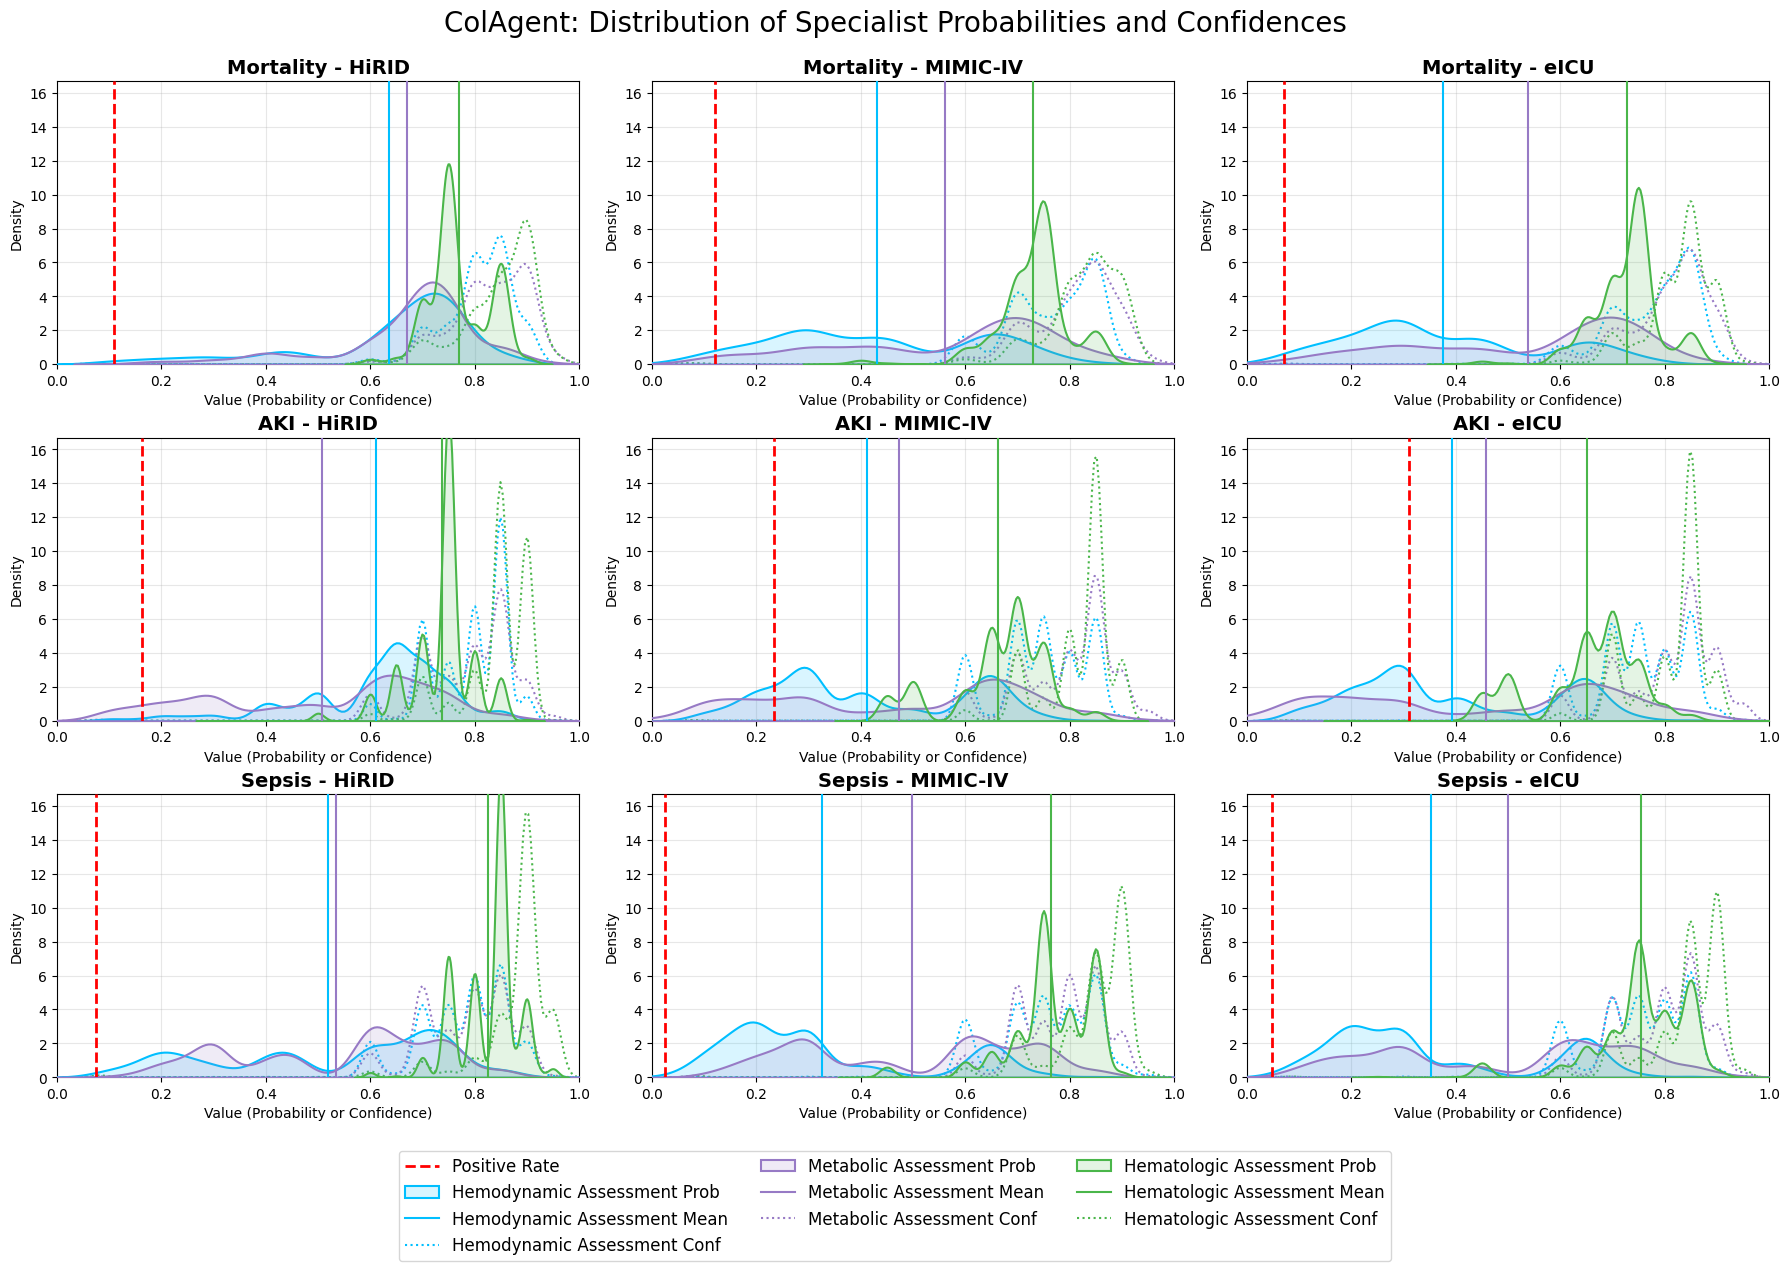

In [22]:
def plot_specialist_density_grid(step_pivot, models_to_include=None, save_suffix=""):
    """
    3x3 grid (task × dataset) of overlayed density plots for specialist probabilities and confidences.
    Each specialist's probability and confidence use a unique color pair.
    Adds vertical lines for the positive rate (red, dashed) and for each specialist's mean (solid, matching color).
    All y axes are set to the same limit.
    """
    tasks = ["Mortality", "AKI", "Sepsis"]
    datasets = ["HiRID", "MIMIC-IV", "eICU"]
    specialists = [
        ("Hemodynamic Assessment", "#00BFFF"),
        ("Metabolic Assessment", "#977AC5"),
        ("Hematologic Assessment", "#4ab64a"),
    ]
    conf_linestyle = ":"

    if models_to_include is not None:
        if isinstance(models_to_include, str):
            models_to_include = [models_to_include]
        plot_df = step_pivot[step_pivot["model_name"].isin(models_to_include)].copy()
    else:
        plot_df = step_pivot.copy()

    fig, axes = plt.subplots(3, 3, figsize=(18, 12))
    y_max = 0  # Track max y for axis scaling

    # First pass: plot and record max y
    for i, task in enumerate(tasks):
        for j, dataset in enumerate(datasets):
            ax = axes[i, j]
            data = plot_df[(plot_df["task"] == task) & (plot_df["dataset"] == dataset)]
            # Compute positive rate for this task-dataset
            if "label" in data.columns and data["label"].notna().sum() > 0:
                positive_rate = data["label"].mean()
                ax.axvline(
                    positive_rate,
                    color="red",
                    linestyle="--",
                    linewidth=2,
                    label="Positive Rate" if (i == 0 and j == 0) else None,
                    zorder=10,
                )
            for step, color in specialists:
                prob_col = f"probabilities_{step}"
                conf_col = f"Confidence_numeric_{step}"
                # Plot probability KDE
                if prob_col in data.columns and data[prob_col].notna().sum() > 0:
                    vals = data[prob_col].dropna().clip(0, 1)
                    sns.kdeplot(
                        vals,
                        ax=ax,
                        color=color,
                        label=f"{step} Prob",
                        linewidth=1.5,
                        fill=True,
                        alpha=0.15,
                        zorder=3,
                    )
                    # Mean line for probability
                    mean_prob = vals.mean()
                    ax.axvline(
                        mean_prob,
                        color=color,
                        linestyle="-",
                        linewidth=1.5,
                        label=f"{step} Mean" if (i == 0 and j == 0) else None,
                        zorder=11,
                    )
                # Plot confidence KDE (dashed line, same color)
                if conf_col in data.columns and data[conf_col].notna().sum() > 0:
                    conf_vals = data[conf_col].dropna()
                    if conf_vals.max() > 1.01:
                        conf_vals = conf_vals / 100.0
                    sns.kdeplot(
                        conf_vals.clip(0, 1),
                        ax=ax,
                        color=color,
                        label=f"{step} Conf",
                        linewidth=1.5,
                        linestyle=conf_linestyle,
                        fill=False,
                        zorder=2,
                    )
            # After all plots, update y_max using all lines on this axis
            lines = ax.get_lines()
            if lines:
                y_max = max(
                    y_max,
                    max(
                        np.max(line.get_ydata())
                        for line in lines
                        if hasattr(line, "get_ydata") and len(line.get_ydata()) > 0
                    ),
                )
            ax.set_xlim(0, 1)
            ax.set_title(f"{task} - {dataset}", fontsize=14, fontweight="bold")
            ax.set_xlabel("Value (Probability or Confidence)", fontsize=10)
            ax.set_ylabel("Density", fontsize=10)
            ax.grid(True, alpha=0.3)

    # Set all y axes to the same limit
    for ax in axes.flat:
        ax.set_ylim(0, y_max * 1.05 if y_max > 0 else 1)

    # Legend below grid
    handles, labels = axes[0, 0].get_legend_handles_labels()
    fig.legend(
        handles,
        labels,
        loc="lower center",
        bbox_to_anchor=(0.5, -0.06),
        ncol=3,
        fontsize=12,
        frameon=True,
    )
    plt.tight_layout()
    plt.subplots_adjust(top=0.93, bottom=0.1)
    fig.suptitle(
        "ColAgent: Distribution of Specialist Probabilities and Confidences",
        fontsize=20,
        y=0.99,
    )
    save_path = os.path.join(
        OUTPUT_BASE_DIR, f"cra_specialist_density_grid{save_suffix}.png"
    )
    plt.savefig(save_path, dpi=400, bbox_inches="tight")
    print(f"Specialist density grid saved to: {save_path}")
    plt.show()


# Example usage:
plot_specialist_density_grid(step_pivot)

Specialist density by model grid saved to: ./notebook_output/pulse_agents_colagent/cra_specialist_density_by_model.png


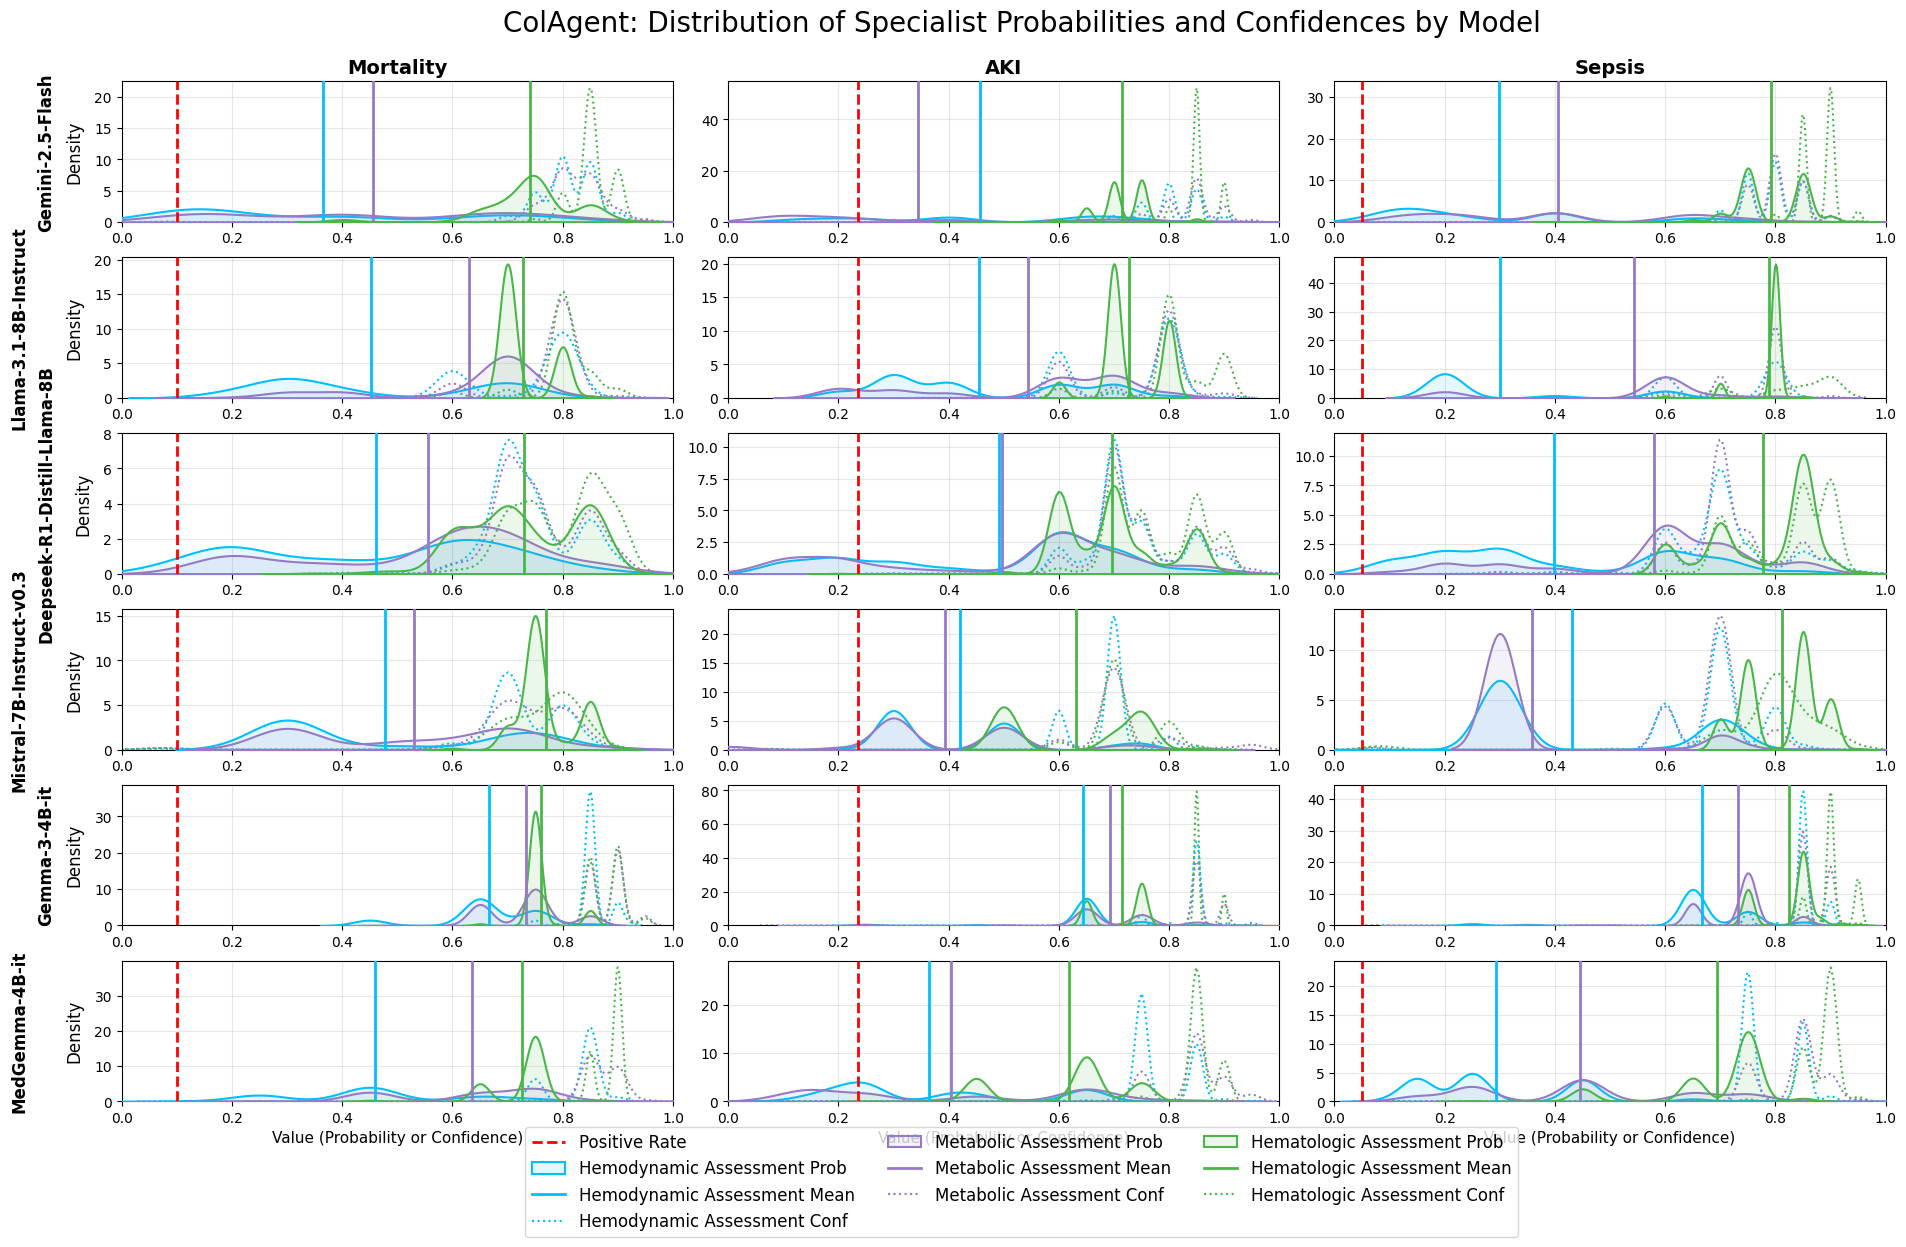

In [26]:
def plot_specialist_density_by_model(
    step_pivot, tasks=None, models=None, save_suffix=""
):
    """
    For each model, create a row of subplots (one per task), overlaying density plots for
    specialist probabilities and confidences (matching colors), aggregated across datasets.
    Adds vertical lines for the positive rate (red, dashed) and for each specialist's mean (solid, matching color).
    """
    import matplotlib.pyplot as plt
    import seaborn as sns

    if tasks is None:
        tasks = ["Mortality", "AKI", "Sepsis"]
    if models is None:
        models = [m for m in LLM_MODELS if m in step_pivot["model_name"].unique()]
        if not models:
            models = sorted(step_pivot["model_name"].unique())
    specialists = [
        ("Hemodynamic Assessment", "#00BFFF"),
        ("Metabolic Assessment", "#977AC5"),
        ("Hematologic Assessment", "#4ab64a"),
    ]
    conf_linestyle = ":"

    fig, axes = plt.subplots(
        len(models),
        len(tasks),
        figsize=(18, 12),
    )
    if len(models) == 1:
        axes = axes[None, :]  # Ensure 2D

    for i, model in enumerate(models):
        for j, task in enumerate(tasks):
            ax = axes[i, j]
            data = step_pivot[
                (step_pivot["model_name"] == model) & (step_pivot["task"] == task)
            ]
            # Compute positive rate for this model-task
            if "label" in data.columns and data["label"].notna().sum() > 0:
                positive_rate = data["label"].mean()
                ax.axvline(
                    positive_rate,
                    color="red",
                    linestyle="--",
                    linewidth=2,
                    label="Positive Rate" if (i == 0 and j == 0) else None,
                    zorder=10,
                )
            # Plot densities and means
            for step, color in specialists:
                prob_col = f"probabilities_{step}"
                conf_col = f"Confidence_numeric_{step}"
                # Probability KDE
                if prob_col in data.columns and data[prob_col].notna().sum() > 0:
                    vals = data[prob_col].dropna().clip(0, 1)
                    sns.kdeplot(
                        vals,
                        ax=ax,
                        color=color,
                        label=f"{step} Prob",
                        linewidth=1.5,
                        fill=True,
                        alpha=0.1,
                        zorder=3,
                    )
                    # Mean line for probability
                    mean_prob = vals.mean()
                    ax.axvline(
                        mean_prob,
                        color=color,
                        linestyle="-",
                        linewidth=2,
                        label=f"{step} Mean" if (i == 0 and j == 0) else None,
                        zorder=11,
                    )
                # Confidence KDE (dashed)
                if conf_col in data.columns and data[conf_col].notna().sum() > 0:
                    conf_vals = data[conf_col].dropna()
                    if conf_vals.max() > 1.01:
                        conf_vals = conf_vals / 100.0
                    sns.kdeplot(
                        conf_vals.clip(0, 1),
                        ax=ax,
                        color=color,
                        label=f"{step} Conf",
                        linewidth=1.5,
                        linestyle=conf_linestyle,
                        fill=False,
                        zorder=2,
                    )
            ax.set_xlim(0, 1)
            ax.set_ylim(bottom=0)
            if i == 0:
                ax.set_title(task, fontsize=14, fontweight="bold")
            if j == 0:
                ax.set_ylabel("Density", fontsize=12, labelpad=8)
                # Add model name as a separate annotation on the left, vertically centered, rotated 90°
                offset = -0.12 if i % 2 == 0 else -0.17
                ax.annotate(
                    model,
                    xy=(0, 0.5),
                    xycoords="axes fraction",
                    xytext=(offset, 0.5),
                    textcoords="axes fraction",
                    ha="right",
                    va="center",
                    fontsize=12,
                    fontweight="bold",
                    rotation=90,
                    annotation_clip=False,
                )
            else:
                ax.set_ylabel("")
            if i == len(models) - 1:
                ax.set_xlabel("Value (Probability or Confidence)", fontsize=11)
            else:
                ax.set_xlabel("")
            ax.grid(True, alpha=0.3)
    # Legend below grid
    handles, labels = axes[0, 0].get_legend_handles_labels()
    fig.legend(
        handles,
        labels,
        loc="lower center",
        bbox_to_anchor=(0.5, -0.04),
        ncol=3,
        fontsize=12,
        frameon=True,
    )
    plt.subplots_adjust(
        left=0, right=0.98, top=0.93, bottom=0.08, hspace=0.25, wspace=0.1
    )
    fig.suptitle(
        "ColAgent: Distribution of Specialist Probabilities and Confidences by Model",
        fontsize=20,
        y=0.99,
    )
    save_path = os.path.join(
        OUTPUT_BASE_DIR, f"cra_specialist_density_by_model{save_suffix}.png"
    )
    plt.savefig(save_path, dpi=400, bbox_inches="tight")
    print(f"Specialist density by model grid saved to: {save_path}")
    plt.show()


# Example usage:
plot_specialist_density_by_model(step_pivot)

In [24]:
def summarize_specialist_distributions(step_pivot, models=None):
    """
    Summarize the distribution of specialist probabilities and confidences by model.
    Reports mean ± std for each specialist and model, and highlights largest/smallest.
    Also provides insights at the task level (highest/lowest mean probability and confidence per specialist and per task).
    """
    specialists = [
        ("Hemodynamic Assessment", "#00BFFF"),
        ("Metabolic Assessment", "#977AC5"),
        ("Hematologic Assessment", "#4ab64a"),
    ]
    if models is None:
        models = [m for m in LLM_MODELS if m in step_pivot["model_name"].unique()]
        if not models:
            models = sorted(step_pivot["model_name"].unique())
    summary_rows = []
    for model in models:
        model_data = step_pivot[step_pivot["model_name"] == model]
        for step, _ in specialists:
            prob_col = f"probabilities_{step}"
            conf_col = f"Confidence_numeric_{step}"
            # Probabilities
            probs = (
                pd.to_numeric(model_data[prob_col], errors="coerce").dropna().clip(0, 1)
            )
            # Confidences (scale if needed)
            confs = pd.to_numeric(model_data[conf_col], errors="coerce").dropna()
            if len(confs) > 0 and confs.max() > 1.01:
                confs = confs / 100.0
            confs = confs.clip(0, 1)
            summary_rows.append(
                {
                    "Model": model,
                    "Specialist": step,
                    "Prob_Mean": probs.mean(),
                    "Prob_Std": probs.std(),
                    "Prob_Min": probs.min(),
                    "Prob_Max": probs.max(),
                    "Conf_Mean": confs.mean(),
                    "Conf_Std": confs.std(),
                    "Conf_Min": confs.min(),
                    "Conf_Max": confs.max(),
                    "n_Prob": len(probs),
                    "n_Conf": len(confs),
                }
            )
    summary_df = pd.DataFrame(summary_rows)
    pd.set_option("display.float_format", lambda x: f"{x:.3f}")
    print("=== Specialist Probability & Confidence Distribution Summary by Model ===")
    # Print table with mean ± std for each
    for _, row in summary_df.iterrows():
        print(
            f"{row['Model']:<22} | {row['Specialist']:<24} | "
            f"Prob: {row['Prob_Mean']:.3f} ± {row['Prob_Std']:.3f} "
            f"(min={row['Prob_Min']:.3f}, max={row['Prob_Max']:.3f}, n={int(row['n_Prob'])}) | "
            f"Conf: {row['Conf_Mean']:.3f} ± {row['Conf_Std']:.3f} "
            f"(min={row['Conf_Min']:.3f}, max={row['Conf_Max']:.3f}, n={int(row['n_Conf'])})"
        )
    print("\n--- Actionable Insights ---")
    # 1. Largest and smallest mean probability/confidence across all (model, specialist)
    max_prob = summary_df.loc[summary_df["Prob_Mean"].idxmax()]
    min_prob = summary_df.loc[summary_df["Prob_Mean"].idxmin()]
    max_conf = summary_df.loc[summary_df["Conf_Mean"].idxmax()]
    min_conf = summary_df.loc[summary_df["Conf_Mean"].idxmin()]
    print(
        f"- Highest mean specialist probability: {max_prob['Prob_Mean']:.3f} ± {max_prob['Prob_Std']:.3f} "
        f"({max_prob['Model']} - {max_prob['Specialist']})"
    )
    print(
        f"- Lowest mean specialist probability: {min_prob['Prob_Mean']:.3f} ± {min_prob['Prob_Std']:.3f} "
        f"({min_prob['Model']} - {min_prob['Specialist']})"
    )
    print(
        f"- Highest mean specialist confidence: {max_conf['Conf_Mean']:.3f} ± {max_conf['Conf_Std']:.3f} "
        f"({max_conf['Model']} - {max_conf['Specialist']})"
    )
    print(
        f"- Lowest mean specialist confidence: {min_conf['Conf_Mean']:.3f} ± {min_conf['Conf_Std']:.3f} "
        f"({min_conf['Model']} - {min_conf['Specialist']})"
    )
    # 2. Largest and smallest std for probabilities/confidences
    max_prob_std = summary_df.loc[summary_df["Prob_Std"].idxmax()]
    min_prob_std = summary_df.loc[summary_df["Prob_Std"].idxmin()]
    max_conf_std = summary_df.loc[summary_df["Conf_Std"].idxmax()]
    min_conf_std = summary_df.loc[summary_df["Conf_Std"].idxmin()]
    print(
        f"- Largest std of probabilities: {max_prob_std['Prob_Std']:.3f} (mean={max_prob_std['Prob_Mean']:.3f}) "
        f"({max_prob_std['Model']} - {max_prob_std['Specialist']})"
    )
    print(
        f"- Smallest std of probabilities: {min_prob_std['Prob_Std']:.3f} (mean={min_prob_std['Prob_Mean']:.3f}) "
        f"({min_prob_std['Model']} - {min_prob_std['Specialist']})"
    )
    print(
        f"- Largest std of confidences: {max_conf_std['Conf_Std']:.3f} (mean={max_conf_std['Conf_Mean']:.3f}) "
        f"({max_conf_std['Model']} - {max_conf_std['Specialist']})"
    )
    print(
        f"- Smallest std of confidences: {min_conf_std['Conf_Std']:.3f} (mean={min_conf_std['Conf_Mean']:.3f}) "
        f"({min_conf_std['Model']} - {min_conf_std['Specialist']})"
    )
    # 3. Per-model summary (mean ± std across specialists)
    print("\n--- Per-model summary (mean ± std across specialists) ---")
    for model in models:
        sub = summary_df[summary_df["Model"] == model]
        print(
            f"{model}: Probabilities: {sub['Prob_Mean'].mean():.3f} ± {sub['Prob_Mean'].std():.3f} | "
            f"Confidences: {sub['Conf_Mean'].mean():.3f} ± {sub['Conf_Mean'].std():.3f}"
        )

    # --- Task-level insights ---
    print("\n=== Task-level Specialist Probability & Confidence Insights ===")
    tasks = step_pivot["task"].unique()
    for task in tasks:
        print(f"\nTask: {task}")
        task_rows = []
        for step, _ in specialists:
            prob_col = f"probabilities_{step}"
            conf_col = f"Confidence_numeric_{step}"
            # All models, this task
            mask = step_pivot["task"] == task
            probs = (
                pd.to_numeric(step_pivot.loc[mask, prob_col], errors="coerce")
                .dropna()
                .clip(0, 1)
            )
            confs = pd.to_numeric(
                step_pivot.loc[mask, conf_col], errors="coerce"
            ).dropna()
            if len(confs) > 0 and confs.max() > 1.01:
                confs = confs / 100.0
            confs = confs.clip(0, 1)
            task_rows.append(
                {
                    "Specialist": step,
                    "Prob_Mean": probs.mean(),
                    "Prob_Std": probs.std(),
                    "Prob_Min": probs.min(),
                    "Prob_Max": probs.max(),
                    "Conf_Mean": confs.mean(),
                    "Conf_Std": confs.std(),
                    "Conf_Min": confs.min(),
                    "Conf_Max": confs.max(),
                    "n_Prob": len(probs),
                    "n_Conf": len(confs),
                }
            )
        task_df = pd.DataFrame(task_rows)
        for _, row in task_df.iterrows():
            print(
                f"  {row['Specialist']:<24} | "
                f"Prob: {row['Prob_Mean']:.3f} ± {row['Prob_Std']:.3f} "
                f"(min={row['Prob_Min']:.3f}, max={row['Prob_Max']:.3f}, n={int(row['n_Prob'])}) | "
                f"Conf: {row['Conf_Mean']:.3f} ± {row['Conf_Std']:.3f} "
                f"(min={row['Conf_Min']:.3f}, max={row['Conf_Max']:.3f}, n={int(row['n_Conf'])})"
            )
        # Highlight highest/lowest mean probability/confidence per specialist for this task
        max_prob_row = task_df.loc[task_df["Prob_Mean"].idxmax()]
        min_prob_row = task_df.loc[task_df["Prob_Mean"].idxmin()]
        max_conf_row = task_df.loc[task_df["Conf_Mean"].idxmax()]
        min_conf_row = task_df.loc[task_df["Conf_Mean"].idxmin()]
        print(
            f"  -> Highest mean probability: {max_prob_row['Specialist']} ({max_prob_row['Prob_Mean']:.3f})"
        )
        print(
            f"  -> Lowest mean probability: {min_prob_row['Specialist']} ({min_prob_row['Prob_Mean']:.3f})"
        )
        print(
            f"  -> Highest mean confidence: {max_conf_row['Specialist']} ({max_conf_row['Conf_Mean']:.3f})"
        )
        print(
            f"  -> Lowest mean confidence: {min_conf_row['Specialist']} ({min_conf_row['Conf_Mean']:.3f})"
        )

    print("\nInterpretation tips:")
    print("- Means are always shown with their standard deviation (±).")
    print(
        "- Large std indicates more variability in predictions/confidences across samples."
    )
    print(
        "- Compare means and stds across models, specialists, and tasks to identify which are more/less confident or variable."
    )
    print(
        "- Outliers in min/max may indicate unusual predictions or calibration issues."
    )

# Example usage:
summarize_specialist_distributions(step_pivot)

=== Specialist Probability & Confidence Distribution Summary by Model ===
Gemini-2.5-Flash       | Hemodynamic Assessment   | Prob: 0.377 ± 0.234 (min=0.050, max=0.950, n=6189) | Conf: 0.800 ± 0.049 (min=0.550, max=0.950, n=6186)
Gemini-2.5-Flash       | Metabolic Assessment     | Prob: 0.379 ± 0.250 (min=0.050, max=0.950, n=6189) | Conf: 0.820 ± 0.056 (min=0.080, max=0.950, n=6033)
Gemini-2.5-Flash       | Hematologic Assessment   | Prob: 0.753 ± 0.071 (min=0.400, max=0.950, n=6189) | Conf: 0.867 ± 0.032 (min=0.700, max=0.950, n=6182)
Llama-3.1-8B-Instruct  | Hemodynamic Assessment   | Prob: 0.382 ± 0.191 (min=0.200, max=0.800, n=6189) | Conf: 0.728 ± 0.095 (min=0.400, max=0.900, n=5551)
Llama-3.1-8B-Instruct  | Metabolic Assessment     | Prob: 0.548 ± 0.185 (min=0.200, max=0.850, n=6189) | Conf: 0.760 ± 0.077 (min=0.400, max=0.900, n=5688)
Llama-3.1-8B-Instruct  | Hematologic Assessment   | Prob: 0.756 ± 0.057 (min=0.600, max=0.850, n=6189) | Conf: 0.811 ± 0.086 (min=0.600, max=0.900